In [2]:
import os, sys
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings

path_to_file= r"/workspaces/project-final/vietnam_housing_dataset.csv"
vietnam_housing = pd.read_csv(r"/workspaces/project-final/vietnam_housing_dataset.csv")
vietnam_housing = vietnam_housing[['Address',	'Area',	'Frontage','Access Road',  'House direction',	'Balcony direction', 	'Floors',	'Bedrooms',	'Bathrooms',	'Legal status',	'Furniture state',	'Price']]

## Chia dữ liệu


In [3]:
from sklearn.model_selection import train_test_split
seed = 42
index_all = np.arange(vietnam_housing.shape[0])
index_train, index_test = train_test_split(index_all, test_size=0.33, random_state=seed)

In [4]:
vietnam_housing_train = vietnam_housing.iloc[index_train]
vietnam_housing_test  = vietnam_housing.iloc[index_test]
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 20253 / test: 9976 - Tỷ lệ: 0.670, 0.330


In [7]:

# Lưu dữ liệu sau khi chia
import os
from pathlib import Path
# define experiment directory (change if you prefer another path)
exps_dir = Path("./exps")
(exps_dir / "data").mkdir(parents=True, exist_ok=True)
vietnam_housing_train.to_excel(f'{exps_dir}/data/train.xlsx', index=None)
vietnam_housing_test.to_excel(f'{exps_dir}/data/test.xlsx', index=None)
np.savez(f'{exps_dir}/data/idx.npz', id_train = index_train, id_test = index_test)


In [9]:
pd.read_excel(f'{exps_dir}/data/train.xlsx')

Address   Area  Frontage  \
0        Đường Ngọc Lâm, Phường Bồ Đề, Long Biên, Hà Nội   44.6       NaN   
1      Đường Thế Lữ, Phường  An Hải Bắc, Sơn Trà, Đà ...   94.6       4.3   
2      358, Phố Đà Nẵng, Phường Vạn Mỹ, Ngô Quyền, Hả...   71.4       4.0   
3      Đường Định Công Thượng, Phường Định Công, Hoàn...   50.0       4.0   
4      Đường Số 6, Phường Linh Tây, Thủ Đức, Hồ Chí Minh   74.0       4.0   
...                                                  ...    ...       ...   
20248   Đường Lê Văn Thọ, Phường 16, Gò Vấp, Hồ Chí Minh   75.0       4.0   
20249                    Xã Tân Bình, Vĩnh Cửu, Đồng Nai  105.0       7.0   
20250  Đường Cầu Diễn, Phường Cầu Diễn, Nam Từ Liêm, ...   34.0       NaN   
20251  Đường Nguyễn Phẩm, Phường Hòa Cường Bắc, Hải C...   82.5       5.5   
20252  Đường Hoàng Diệu 2, Phường Linh Chiểu, Thủ Đức...   50.1       4.0   

       Access Road House direction Balcony direction  Floors  Bedrooms  \
0              NaN             NaN               NaN     6.0       3.0   
1              5.5      Đông - Nam               NaN     3.0       3.0   
2              6.0             Nam               Nam     4.0       4.0   
3              NaN             NaN               NaN     5.0       4.0   
4             10.0       Tây - Bắc         Tây - Bắc     3.0       4.0   
...            ...             ...               ...     ...       ...   
20248          6.0      Đông - Bắc        Đông - Bắc     2.0       3.0   
20249          7.0             NaN               NaN     2.0       4.0   
20250          NaN             NaN               NaN     5.0       5.0   
20251          5.5       Tây - Nam               NaN     NaN       2.0   
20252          7.0             NaN               NaN     3.0       4.0   

       Bathrooms      Legal status Furniture state  Price  
0            4.0  Have certificate            Full   9.35  
1            3.0  Have certificate             NaN   5.30  
2            3.0  Have certificate            Full   5.95  
3            4.0  Have certificate            Full   7.05  
4            4.0  Have certificate             NaN   8.00  
...          ...               ...             ...    ...  
20248        3.0  Have certificate            Full   6.50  
20249        3.0  Have certificate            Full   1.70  
20250        NaN  Have certificate           Basic   5.25  
20251        NaN  Have certificate             NaN   5.20  
20252        5.0               NaN             NaN   7.50  

[20253 rows x 12 columns]

## Tiền xử lý dữ liệu

In [8]:
# create explicit copies of the splits
vietnam_housing_train = vietnam_housing.iloc[index_train].copy()
vietnam_housing_test  = vietnam_housing.iloc[index_test].copy()
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 20253 / test: 9976 - Tỷ lệ: 0.670, 0.330


In [9]:
vietnam_housing_train.isna().any()

Address              False
Area                 False
Frontage              True
Access Road           True
House direction       True
Balcony direction     True
Floors                True
Bedrooms              True
Bathrooms             True
Legal status          True
Furniture state       True
Price                False
dtype: bool

In [12]:
vietnam_housing_train.dropna(inplace=True)

In [13]:
vietnam_housing_train.drop_duplicates(inplace=True)

In [10]:
# Safe NA fill: tìm biến với khoảng trắng hoặc gạch dưới trước khi fillna
vietnam_housing_train = vietnam_housing_train.copy()

def colname(df, name):
    for cand in (name, name.replace(' ', '_'), name.lower().replace(' ', '_')):
        if cand in df.columns:
            return cand
    return None

for src in ['Frontage','Access Road','Floors','Bedrooms','Bathrooms','Area','Price']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna(vietnam_housing_train[c].median())
    else:
        print(f"Warning: numeric column not found: {src}")

for src in ['House direction','Balcony direction','Legal status','Furniture state','Address']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna('Unknown')
    else:
        print(f"Warning: categorical column not found: {src}")
# ...existing code...

In [16]:
# Kiểm tra trùng lặp lần nữa
vietnam_housing_train.drop_duplicates(inplace=True)
vietnam_housing_train.describe()

Area     Frontage  Access Road       Floors     Bedrooms  \
count  1774.000000  1774.000000  1774.000000  1774.000000  1774.000000   
mean     69.407621     5.445282     7.536077     3.232807     3.446449   
std      48.324289     4.892505     7.355552     1.275137     1.166464   
min       3.100000     1.000000     1.300000     1.000000     1.000000   
25%      40.000000     4.000000     3.000000     2.000000     3.000000   
50%      60.000000     4.500000     5.000000     3.000000     3.000000   
75%      81.075000     5.000000     8.000000     4.000000     4.000000   
max     501.000000    69.000000    85.000000     7.000000     9.000000   

         Bathrooms        Price  
count  1774.000000  1774.000000  
mean      3.350620     5.433754  
std       1.334584     2.206779  
min       1.000000     1.000000  
25%       2.000000     3.700000  
50%       3.000000     5.200000  
75%       4.000000     7.137500  
max       9.000000    10.000000

## Chuẩn hóa dữ liệu

In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sao chép dữ liệu để không làm thay đổi bản gốc
vietnam_housing_train = pd.DataFrame(vietnam_housing_train)
vietnam_housing_clean = vietnam_housing_train.copy()

def find_col(df, name):
    for cand in (name, name.replace(' ', '_'), name.replace(' ', '_').lower()):
        if cand in df.columns:
            return cand
    return None

# Hàm mã hóa hướng an toàn (tạo cột sin/cos với tên có gạch dưới)
def encode_direction(df, name):
    angle_map = {
        'Đông': 0, 'Đông Nam': 45, 'Nam': 90, 'Tây Nam': 135,
        'Tây': 180, 'Tây Bắc': 225, 'Bắc': 270, 'Đông Bắc': 315
    }
    col = find_col(df, name)
    out_base = name.replace(' ', '_')
    if col is None:
        print(f"Warning: direction column not found: {name} -> creating default {out_base}_sin/{out_base}_cos")
        df[out_base + '_sin'] = 0.0
        df[out_base + '_cos'] = 1.0
        return df
    angles = df[col].map(angle_map).fillna(0).astype(float)
    df[out_base + '_sin'] = np.sin(np.deg2rad(angles))
    df[out_base + '_cos'] = np.cos(np.deg2rad(angles))
    return df

# Mã hóa hướng nhà & ban công -
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'House direction')
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'Balcony direction')

# Mã hóa CÁC BIẾN PHÂN LOẠI KHÁC phân loại khác 
# --- Mã hóa các biến phân loại khác ---
for src in ['Legal status', 'Furniture state']:
    col = find_col(vietnam_housing_clean, src)
    out_col = src.replace(' ', '_')
    if col:
        le = LabelEncoder()
        vietnam_housing_clean[out_col] = le.fit_transform(vietnam_housing_clean[col].astype(str))
    else:
        print(f" Warning: categorical column not found: {src}")

# --- One-Hot Encoding (sử dụng cột mới có dấu gạch dưới) ---
vietnam_housing_clean = pd.get_dummies(
    vietnam_housing_clean,
    columns=['Legal_status', 'Furniture_state'],
    drop_first=True
)

In [12]:
# Chuẩn hóa dữ liệu số
cols_to_scale = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']
scaler = StandardScaler()

vietnam_housing_clean[cols_to_scale] = scaler.fit_transform(vietnam_housing_clean[cols_to_scale])

# Kiểm tra kết quả
print("Dữ liệu sau khi mã hóa & chuẩn hóa:")
print(vietnam_housing_clean[[
    'Address', 'Area', 'Frontage', 'Access Road', 'House direction',
    'Balcony direction', 'Floors', 'Bedrooms', 'Bathrooms', 'Price',
    'House_direction_sin', 'House_direction_cos',
    'Balcony_direction_sin', 'Balcony_direction_cos',
    'Legal_status_1', 
    'Furniture_state_1', 
]].head())

print("Mean sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].mean().round(2))

print("Std sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].std().round(2))


Dữ liệu sau khi mã hóa & chuẩn hóa:
                                                 Address      Area  Frontage  \
20592    Đường Ngọc Lâm, Phường Bồ Đề, Long Biên, Hà Nội -0.497235 -0.156172   
23560  Đường Thế Lữ, Phường  An Hải Bắc, Sơn Trà, Đà ...  0.550150 -0.217197   
27565  358, Phố Đà Nẵng, Phường Vạn Mỹ, Ngô Quyền, Hả...  0.064163 -0.308733   
8361   Đường Định Công Thượng, Phường Định Công, Hoàn... -0.384118 -0.308733   
12193  Đường Số 6, Phường Linh Tây, Thủ Đức, Hồ Chí Minh  0.118627 -0.308733   

       Access Road House direction Balcony direction  Floors  Bedrooms  \
20592    -0.183911         Unknown           Unknown     6.0 -0.347864   
23560    -0.272166      Đông - Nam           Unknown     3.0 -0.347864   
27565    -0.183911             Nam               Nam     4.0  0.478951   
8361     -0.183911         Unknown           Unknown     5.0  0.478951   
12193     0.522131       Tây - Bắc         Tây - Bắc     3.0  0.478951   

       Bathrooms     Price  House_dire

<Axes: title={'center': 'Boxplot sau khi chuẩn hóa (StandardScaler)'}>

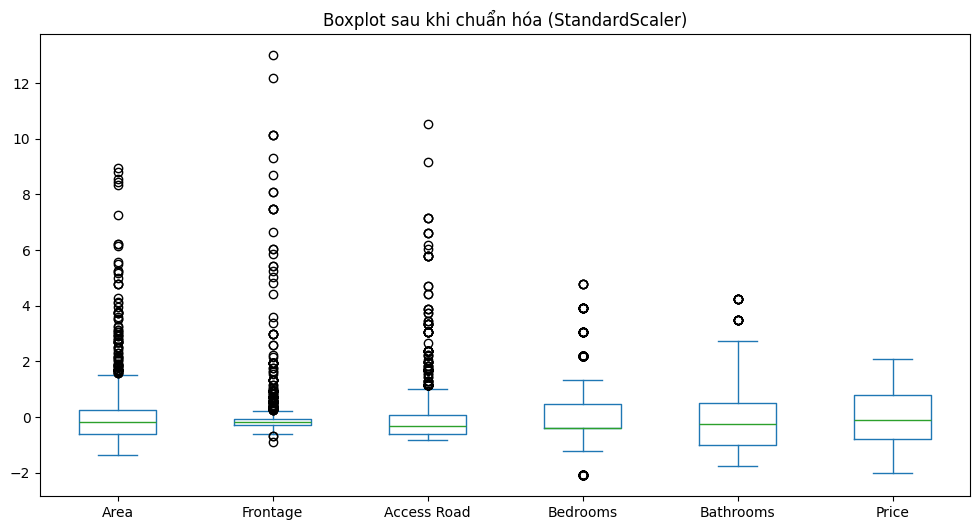

In [19]:
# Vẽ Boxplot sau khi chuẩn hóa
vietnam_housing_clean[cols_to_scale].plot(kind="box", figsize=(12,6), title="Boxplot sau khi chuẩn hóa (StandardScaler)")

Trước / Sau: 20253 / 11183


<Axes: title={'center': 'Boxplot sau khi loại Outlier (IQR)'}>

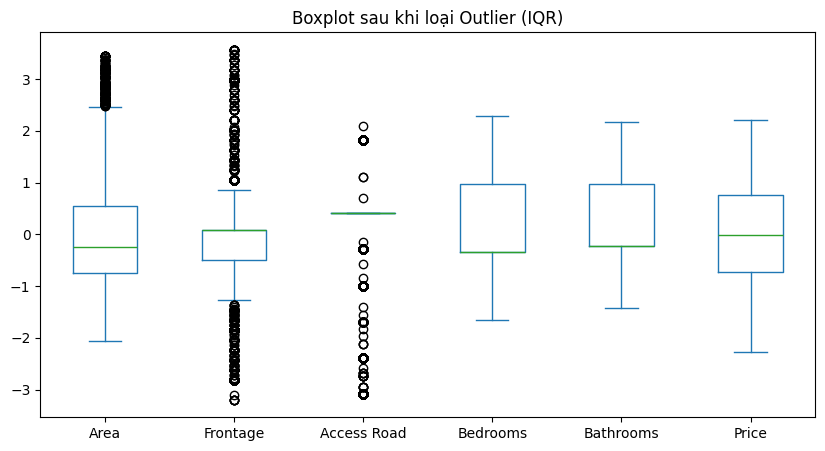

In [13]:
cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms']

mask = np.ones(len(vietnam_housing_clean), bool)
for c in cols:
    q1, q3 = vietnam_housing_clean[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    mask &= (vietnam_housing_clean[c] >= q1 - 1.5*iqr) & (vietnam_housing_clean[c] <= q3 + 1.5*iqr)

vietnam_housing_clean = vietnam_housing_clean[mask].copy()
print("Trước / Sau:", len(mask), "/", len(vietnam_housing_clean))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms','Price']
vietnam_housing_clean[scale_cols] = scaler.fit_transform(vietnam_housing_clean[scale_cols])

vietnam_housing_clean[scale_cols].plot(kind='box', figsize=(10,5),
    title='Boxplot sau khi loại Outlier (IQR)')


In [14]:
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms',
        'Price'], dtype=object),
 'n_features_in_': 6,
 'n_samples_seen_': np.int64(11183),
 'mean_': array([-0.23575143, -0.16999824, -0.23579939, -0.13219568, -0.06406184,
        -0.01957229]),
 'var_': array([0.25297456, 0.0249169 , 0.01586033, 0.39307698, 0.44931351,
        0.91655781]),
 'scale_': array([0.50296576, 0.15785088, 0.12593779, 0.62695851, 0.67030852,
        0.95737026])}

In [15]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


Frontage   Access Road
count  1.118300e+04  1.118300e+04
mean  -4.320567e-17  1.172272e-16
std    1.000045e+00  1.000045e+00
min   -3.198469e+00 -3.091906e+00
25%   -4.923045e-01  4.120158e-01
50%    8.758798e-02  4.120158e-01
75%    8.758798e-02  4.120158e-01
max    3.566943e+00  2.093898e+00

In [16]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


Frontage   Access Road
count  1.118300e+04  1.118300e+04
mean  -4.320567e-17  1.172272e-16
std    1.000045e+00  1.000045e+00
min   -3.198469e+00 -3.091906e+00
25%   -4.923045e-01  4.120158e-01
50%    8.758798e-02  4.120158e-01
75%    8.758798e-02  4.120158e-01
max    3.566943e+00  2.093898e+00

# THỐNG KÊ MÔ TẢ

In [26]:
from IPython.display import display  

print("Kích thước dữ liệu:", vietnam_housing_clean.shape)
print("\n== Thông tin cột ==")
display(pd.DataFrame({
    "dtype": vietnam_housing_clean.dtypes.astype(str),
    "missing": vietnam_housing_clean.isna().sum(),
    "missing_rate": (vietnam_housing_clean.isna().mean()*100).round(2).astype(str) + "%"
}).sort_index())

Kích thước dữ liệu: (11183, 20)

== Thông tin cột ==


dtype  missing missing_rate
Access Road            float64        0         0.0%
Address                 object        0         0.0%
Area                   float64        0         0.0%
Balcony direction       object        0         0.0%
Balcony_direction_cos  float64        0         0.0%
Balcony_direction_sin  float64        0         0.0%
Bathrooms              float64        0         0.0%
Bedrooms               float64        0         0.0%
Floors                 float64        0         0.0%
Frontage               float64        0         0.0%
Furniture state         object        0         0.0%
Furniture_state_1         bool        0         0.0%
Furniture_state_2         bool        0         0.0%
House direction         object        0         0.0%
House_direction_cos    float64        0         0.0%
House_direction_sin    float64        0         0.0%
Legal status            object        0         0.0%
Legal_status_1            bool        0         0.0%
Legal_status_2            bool        0         0.0%
Price                  float64        0         0.0%

In [24]:
#Thống kê mô tả cho biến số
num_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n== Thống kê biến số ({len(num_cols)} cột) ==")
display(vietnam_housing_clean[num_cols].describe().T)


== Thống kê biến số (11 cột) ==


count          mean       std       min       25%  \
Area                   11183.0 -2.541510e-18  1.000045 -2.065039 -0.753115   
Frontage               11183.0 -4.320567e-17  1.000045 -3.198469 -0.492305   
Access Road            11183.0  1.172272e-16  1.000045 -3.091906  0.412016   
Floors                 11183.0  3.445140e+00  1.197613  1.000000  3.000000   
Bedrooms               11183.0 -1.779057e-17  1.000045 -1.662763 -0.343991   
Bathrooms              11183.0 -1.794942e-17  1.000045 -1.425941 -0.224804   
Price                  11183.0  3.176888e-17  1.000045 -2.279624 -0.728058   
House_direction_sin    11183.0  1.251900e-03  0.197005 -1.000000  0.000000   
House_direction_cos    11183.0  9.230976e-01  0.330290 -1.000000  1.000000   
Balcony_direction_sin  11183.0  3.666279e-03  0.137318 -1.000000  0.000000   
Balcony_direction_cos  11183.0  9.650362e-01  0.223252 -1.000000  1.000000   

                            50%       75%       max  
Area                  -0.253335  0.537984  3.453370  
Frontage               0.087588  0.087588  3.566943  
Access Road            0.412016  0.412016  2.093898  
Floors                 3.000000  4.000000  8.000000  
Bedrooms              -0.343991  0.974780  2.293551  
Bathrooms             -0.224804  0.976333  2.177470  
Price                 -0.015941  0.762200  2.200582  
House_direction_sin    0.000000  0.000000  1.000000  
House_direction_cos    1.000000  1.000000  1.000000  
Balcony_direction_sin  0.000000  0.000000  1.000000  
Balcony_direction_cos  1.000000  1.000000  1.000000

In [18]:
#Thống kê cho biến phân loại (nếu còn)
cat_cols = vietnam_housing_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if cat_cols:
    print(f"\n== Thống kê biến phân loại ({len(cat_cols)} cột) ==")
    def cat_summary(s: pd.Series):
        vc = s.value_counts(dropna=False)
        return pd.Series({
            "n_unique": s.nunique(dropna=False),
            "top": vc.index[0],
            "top_freq": int(vc.iloc[0]),
            "top_freq_rate": f"{(vc.iloc[0]/len(s)*100):.2f}%"
        })
    display(pd.DataFrame({c: cat_summary(vietnam_housing_clean[c]) for c in cat_cols}).T)
else:
    print("\n== Không còn biến phân loại ==")


== Thống kê biến phân loại (9 cột) ==


n_unique                                                top  \
Address               4889  Dự án The Empire - Vinhomes Ocean Park 2, Xã L...   
House direction          9                                            Unknown   
Balcony direction        9                                            Unknown   
Legal status             3                                   Have certificate   
Furniture state          3                                            Unknown   
Legal_status_1           2                                              False   
Legal_status_2           2                                              False   
Furniture_state_1        2                                              False   
Furniture_state_2        2                                              False   

                  top_freq top_freq_rate  
Address                 51         0.46%  
House direction       8940        79.94%  
Balcony direction    10152        90.78%  
Legal status          9067        81.08%  
Furniture state       5402        48.31%  
Legal_status_1       10973        98.12%  
Legal_status_2        9277        82.96%  
Furniture_state_1     7260        64.92%  
Furniture_state_2     5781        51.69%

In [25]:
#Ma trận tương quan nhanh
print("\n== Tương quan giữa các biến số (Top 10 cặp mạnh nhất tuyệt đối) ==")
corr = vietnam_housing_clean[num_cols].corr(numeric_only=True)
corr_abs = corr.abs().where(~np.eye(len(corr), dtype=bool))
pairs = (
    corr_abs.unstack()
    .dropna()
    .sort_values(ascending=False)
    .head(10)
)
display(pairs.to_frame("abs_corr"))


== Tương quan giữa các biến số (Top 10 cặp mạnh nhất tuyệt đối) ==


abs_corr
House_direction_cos   Balcony_direction_cos  0.611167
Balcony_direction_cos House_direction_cos    0.611167
Bedrooms              Bathrooms              0.604836
Bathrooms             Bedrooms               0.604836
Balcony_direction_sin House_direction_sin    0.594875
House_direction_sin   Balcony_direction_sin  0.594875
Bathrooms             Floors                 0.516814
Floors                Bathrooms              0.516814
Area                  Floors                 0.395720
Floors                Area                   0.395720

# Vẽ pairplot giữa các biến có tương quan cao nhất

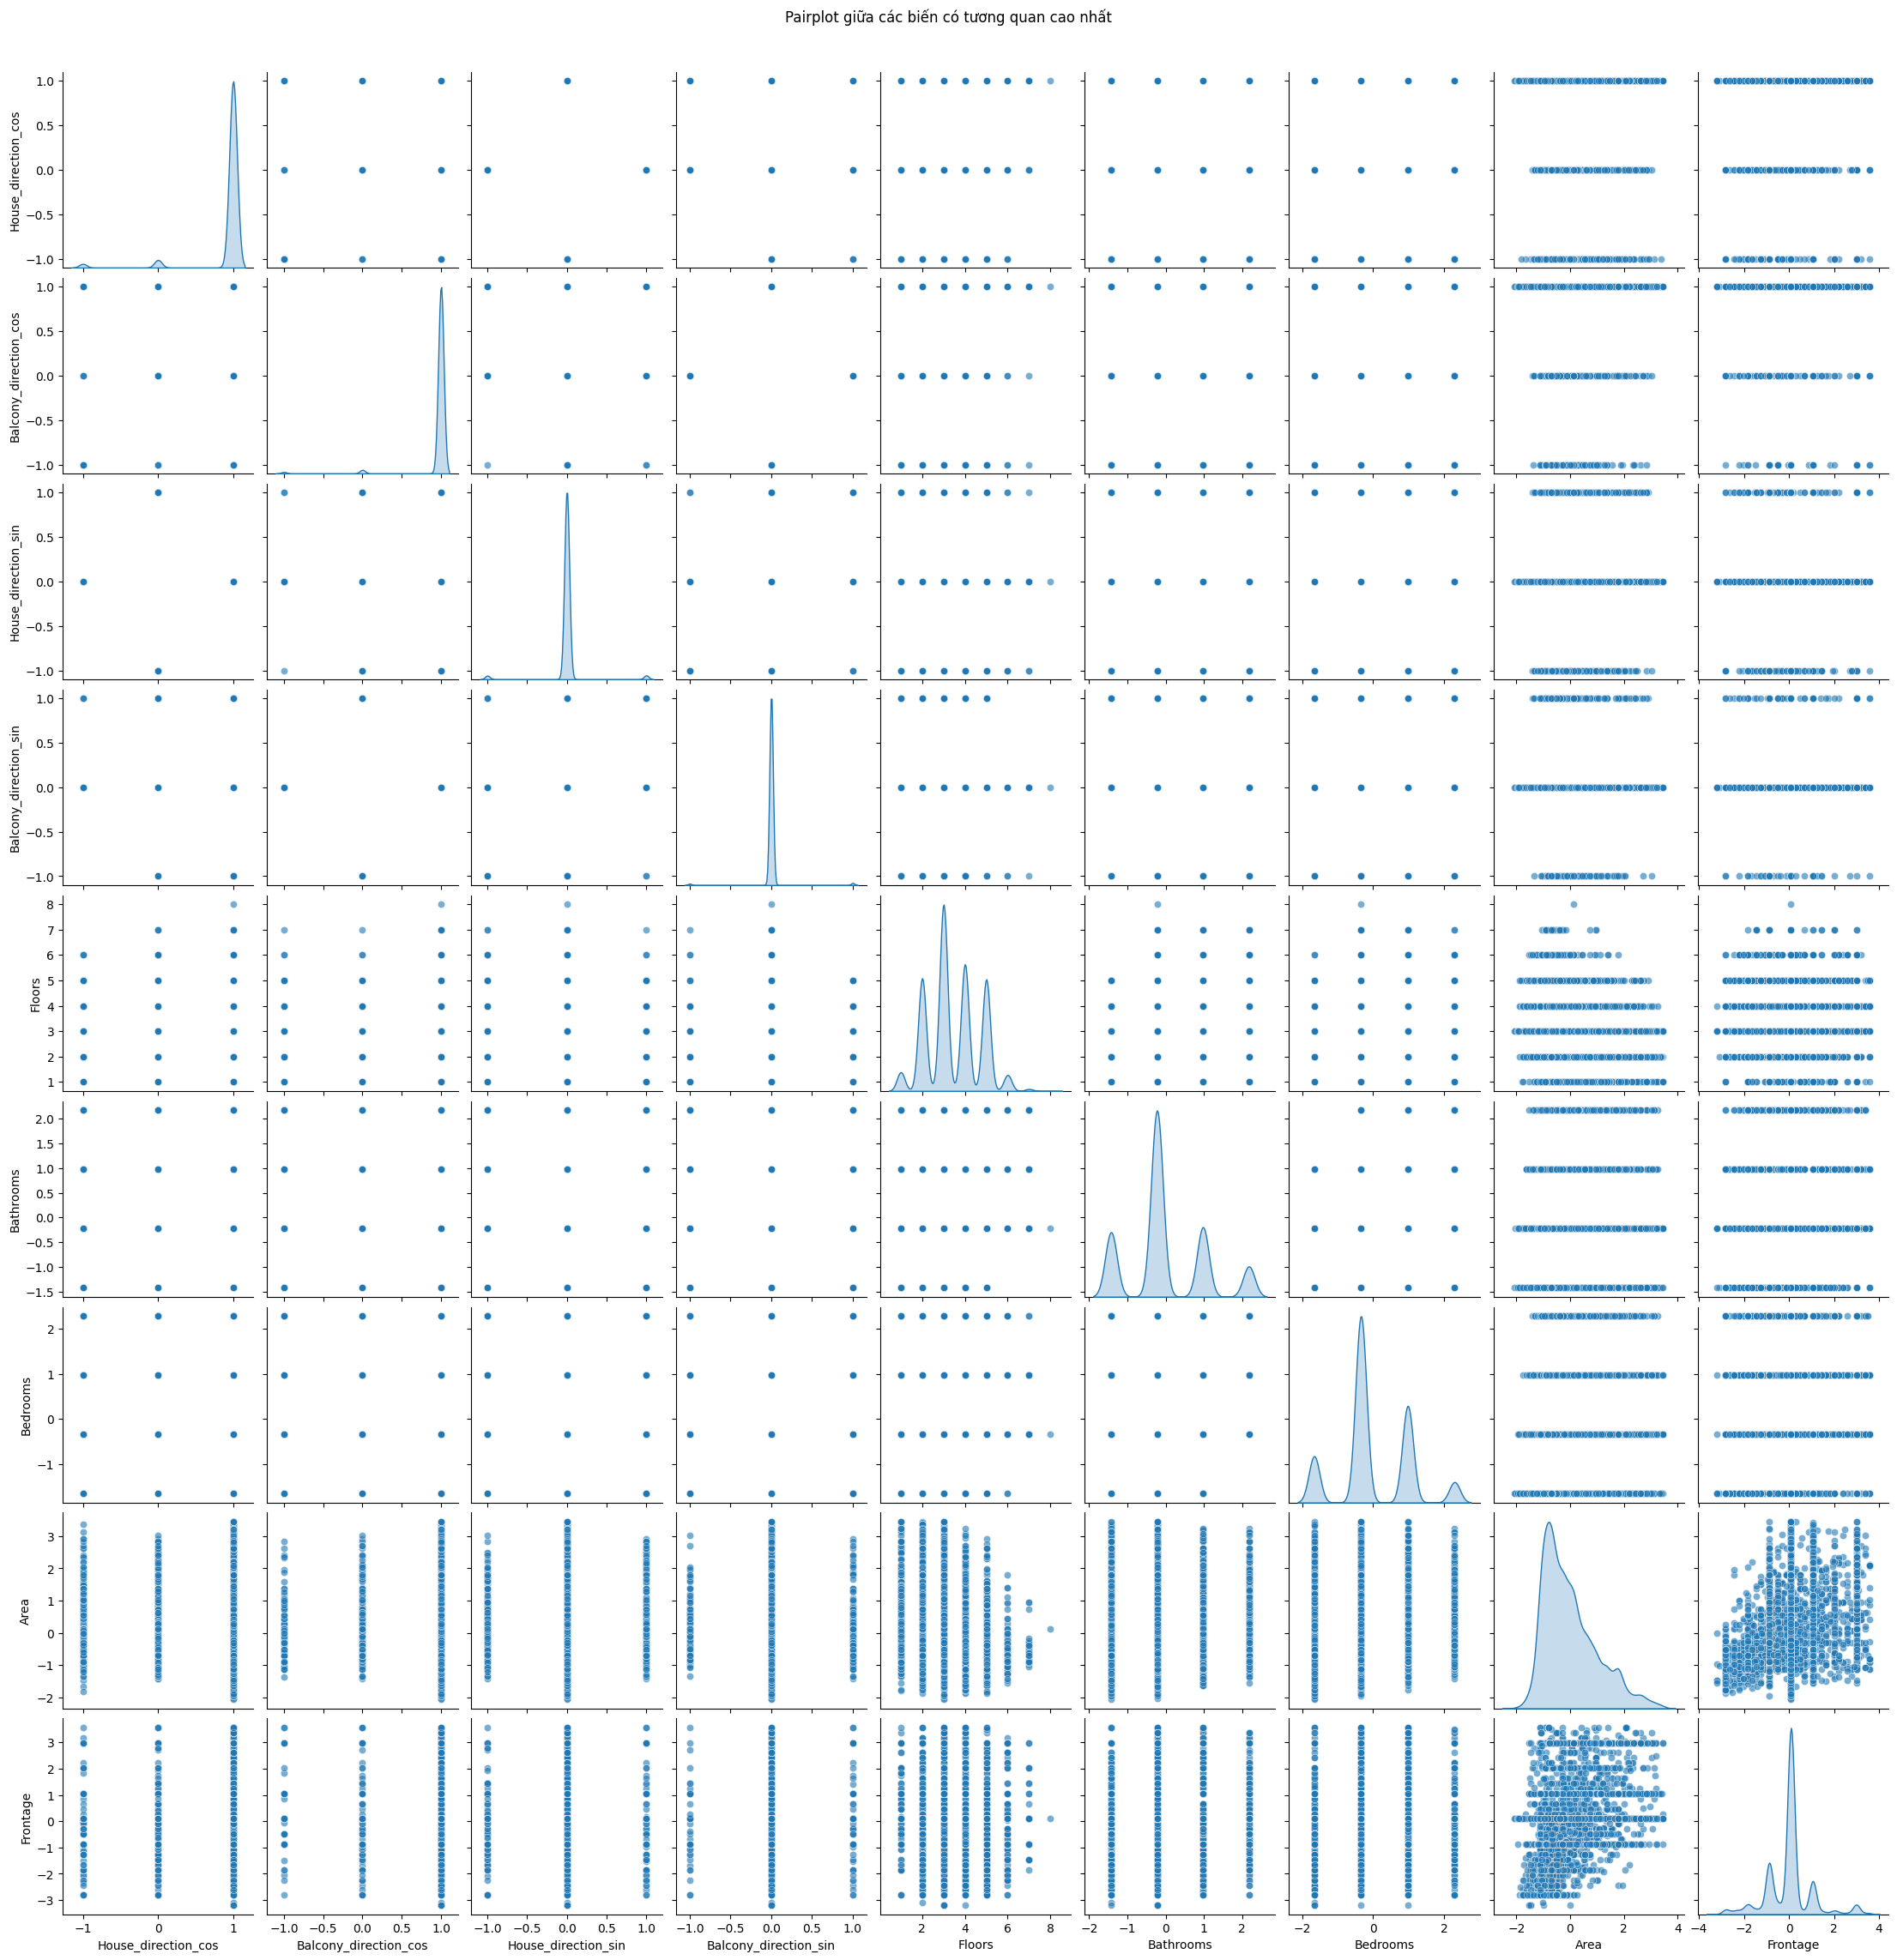

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt


# Danh sách các biến có tương quan cao 
strong_corr_cols = ['House_direction_cos', 'Balcony_direction_cos',
                    'House_direction_sin', 'Balcony_direction_sin',
                    'Floors', 'Bathrooms', 'Bedrooms', 'Area', 'Frontage']

# Vẽ pairplot
sns.pairplot(vietnam_housing_clean[strong_corr_cols], diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle("Pairplot giữa các biến có tương quan cao nhất", y=1.02)
plt.show()

**VISUALIZATION**

**Biểu đồ phân phối (Histogram + KDE) cho các biến số**

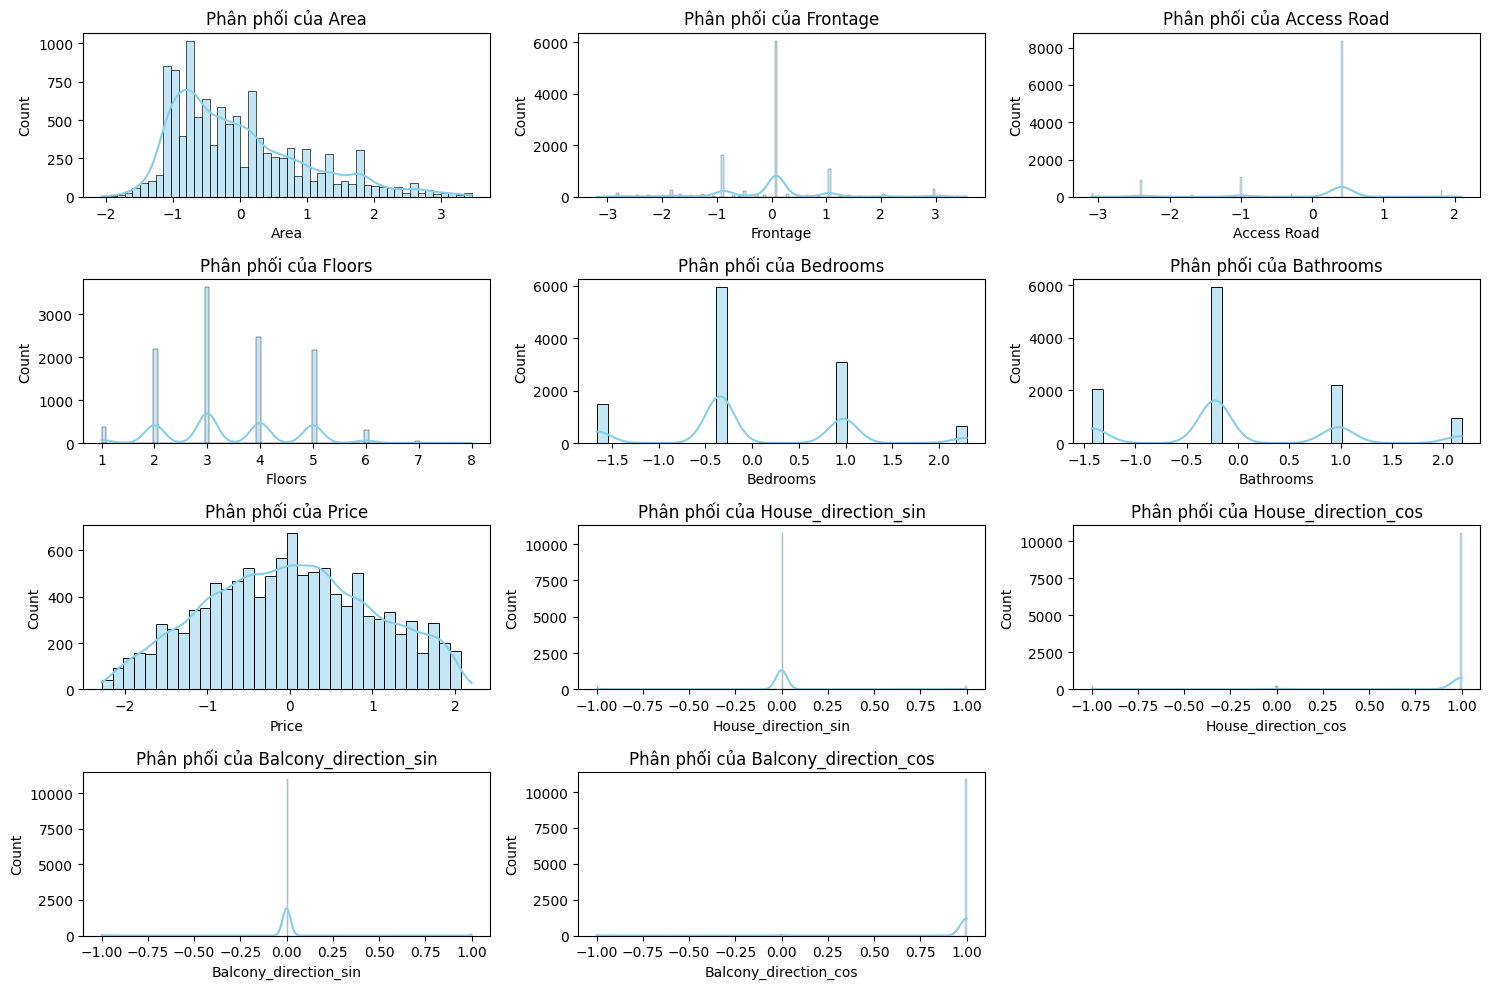

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot((len(num_cols) + 2)//3, 3, i + 1)
    sns.histplot(vietnam_housing_clean[col], kde=True, color='skyblue')
    plt.title(f'Phân phối của {col}')
plt.tight_layout()
plt.show()


**Biểu đồ hộp (Boxplot) để phát hiện ngoại lệ**

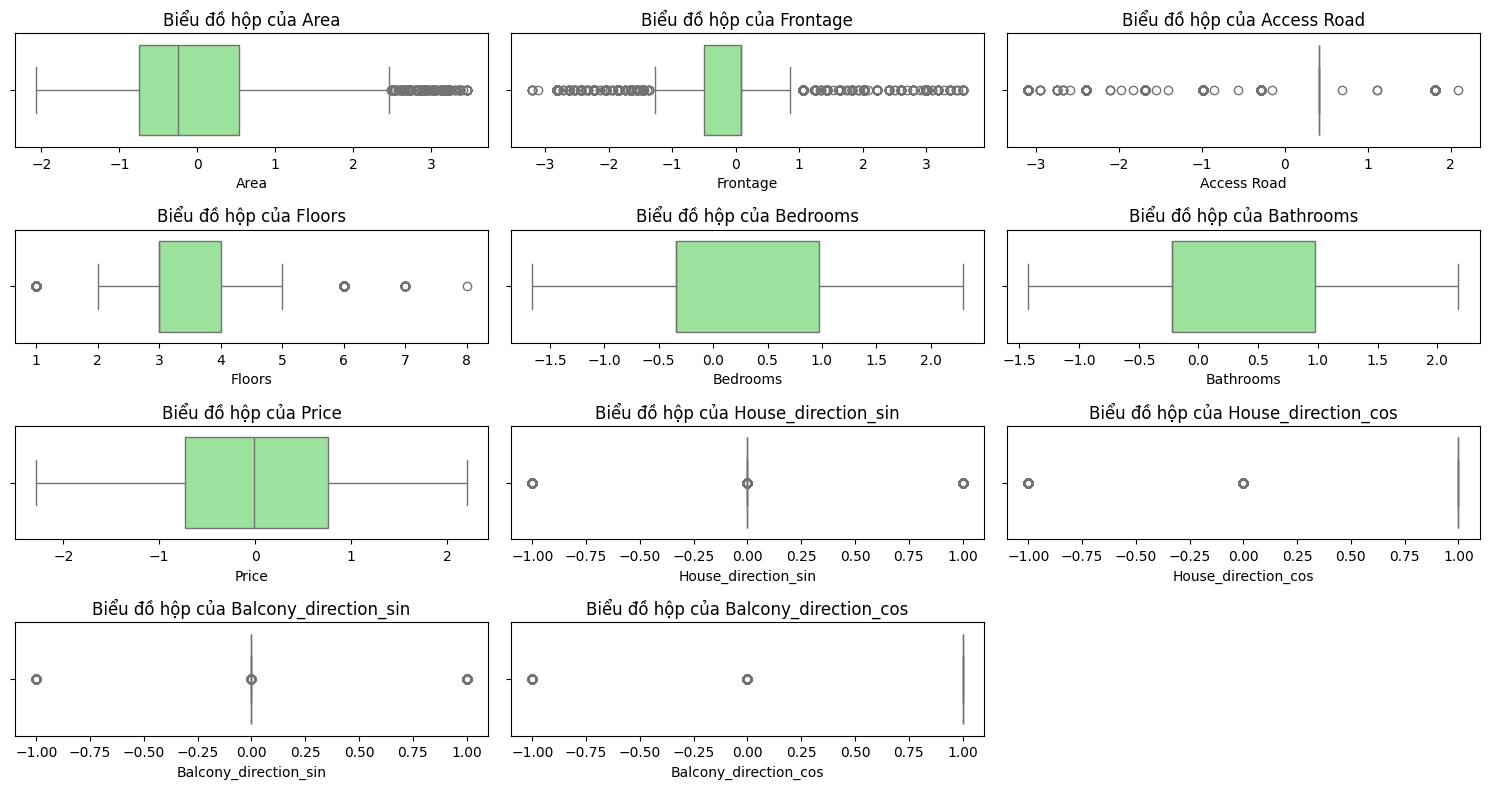

In [ ]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot((len(num_cols) + 2)//3, 3, i + 1)
    sns.boxplot(x=vietnam_housing_clean[col], color='lightgreen')
    plt.title(f'Biểu đồ hộp của {col}')
plt.tight_layout()
plt.show()

**Biểu đồ phân tán (Scatter plot) giữa giá và các biến quan trọng**

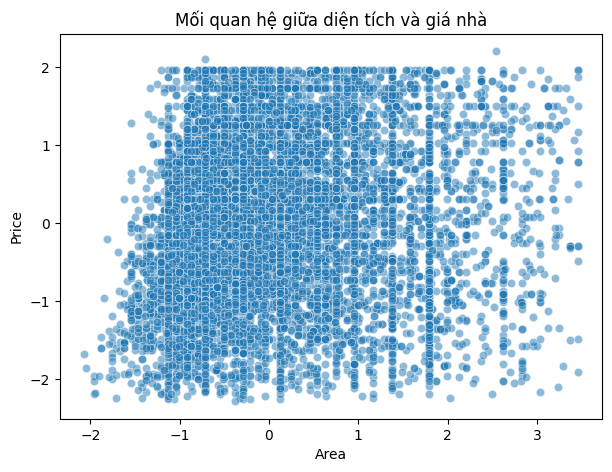

In [34]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Area', y='Price', data=vietnam_housing_clean, alpha=0.5)
plt.title('Mối quan hệ giữa diện tích và giá nhà')
plt.show()

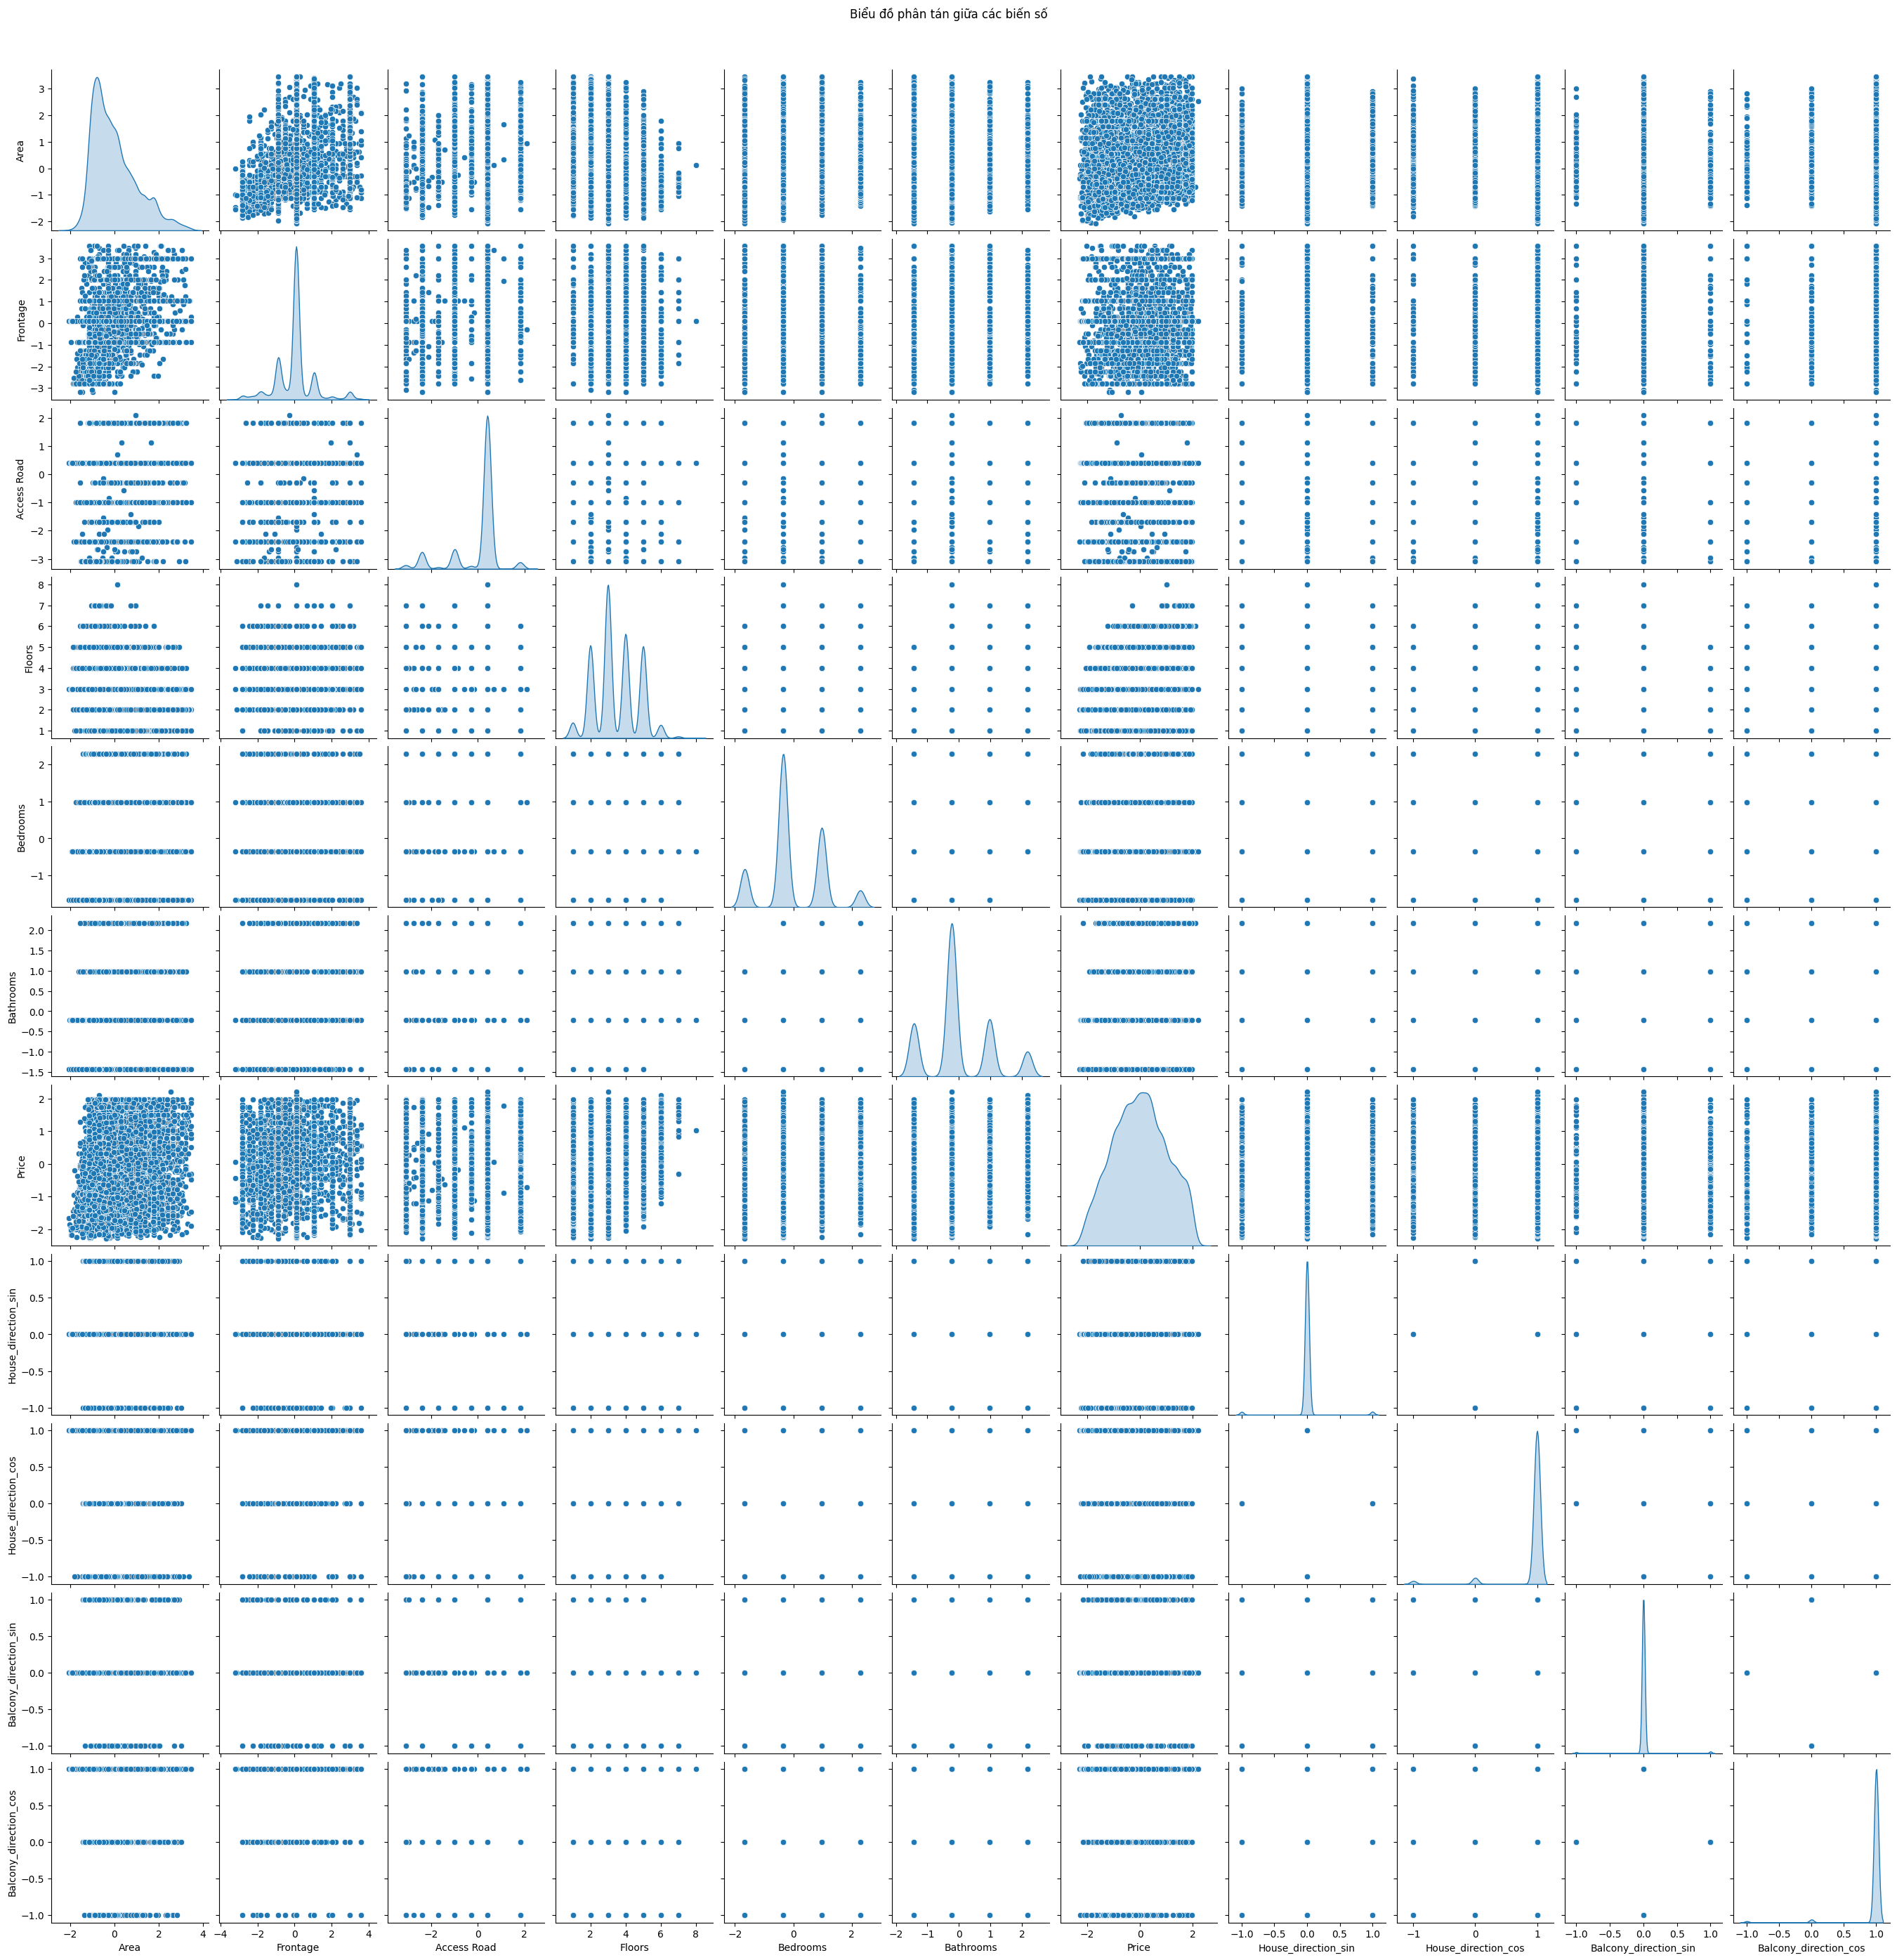

In [35]:
sns.pairplot(vietnam_housing_clean[num_cols], diag_kind='kde')
plt.suptitle('Biểu đồ phân tán giữa các biến số', y=1.02)
plt.show()

**Biểu đồ tương quan (Heatmap)**

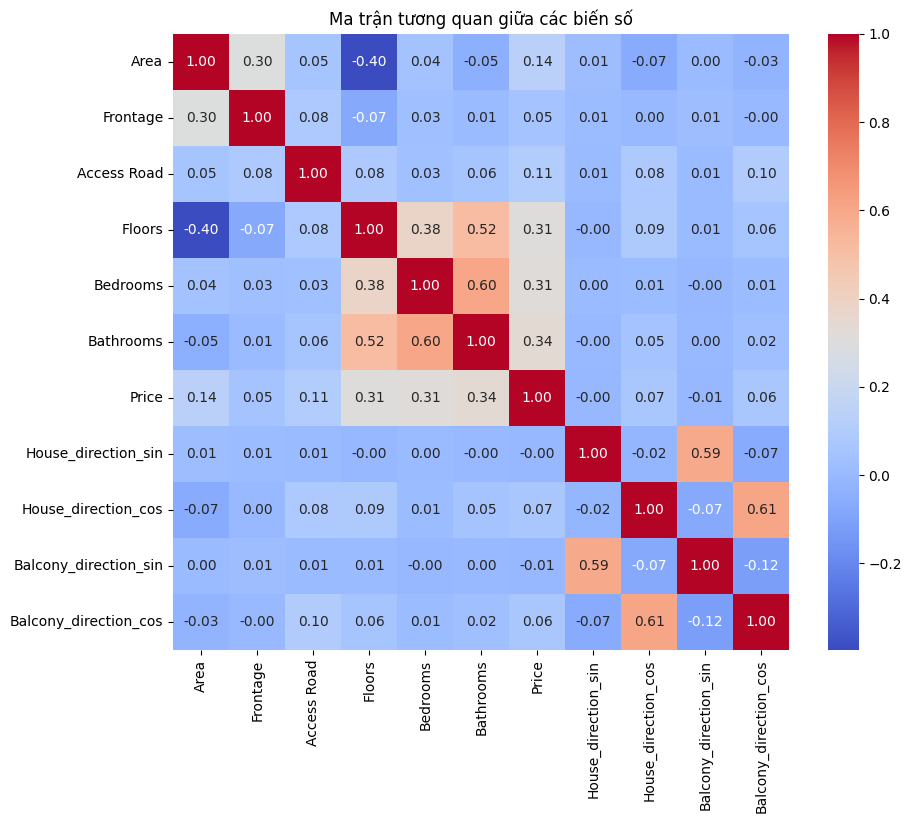

In [37]:
plt.figure(figsize=(10, 8))
corr = vietnam_housing_clean[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Ma trận tương quan giữa các biến số')
plt.show()

**Heatmap cho các biến tương quan cao nhất**

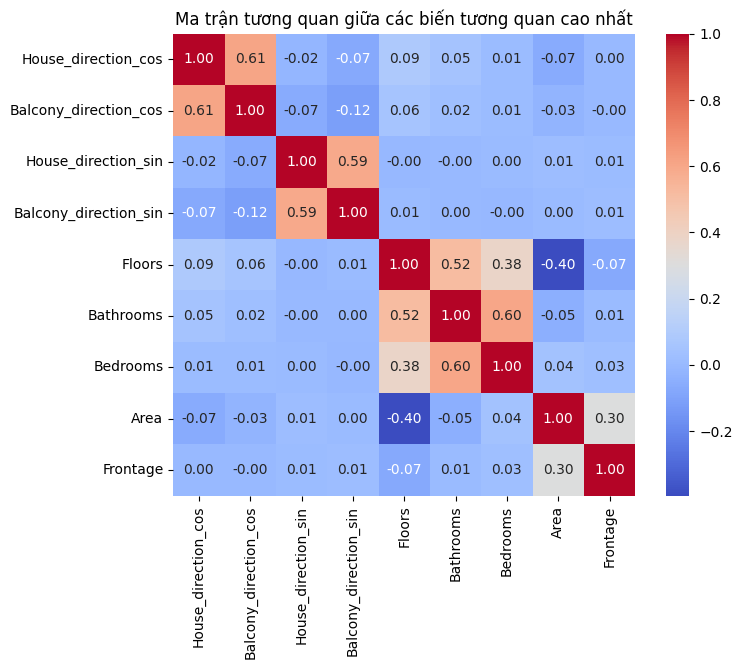

In [38]:
plt.figure(figsize=(8, 6))
corr_strong = vietnam_housing_clean[strong_corr_cols].corr()
sns.heatmap(corr_strong, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Ma trận tương quan giữa các biến tương quan cao nhất")
plt.show()

**Boxplot thể hiện mối quan hệ giữa biến phân loại và giá (Price)**

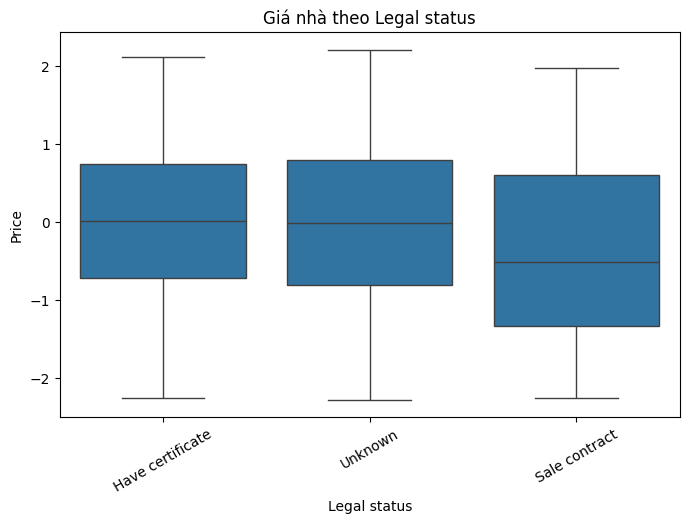

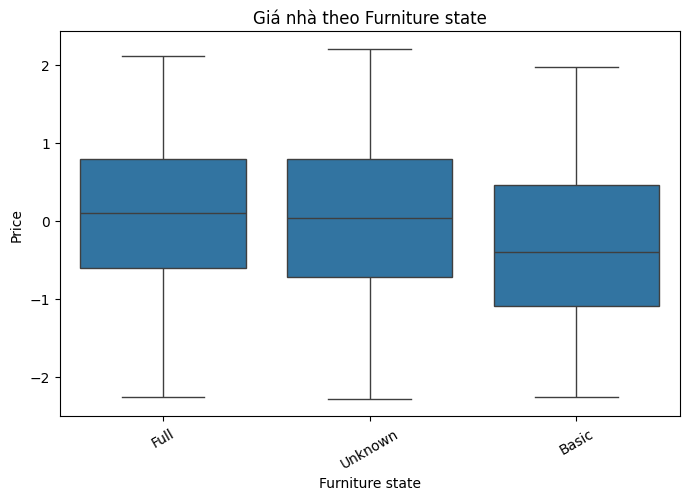

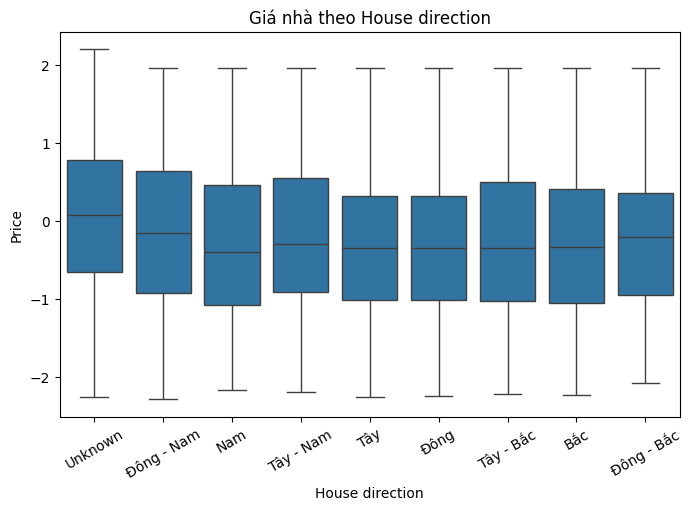

In [39]:
cat_cols = ['Legal status', 'Furniture state', 'House direction']
for col in cat_cols:
    if col in vietnam_housing_clean.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=col, y='Price', data=vietnam_housing_clean)
        plt.title(f"Giá nhà theo {col}")
        plt.xticks(rotation=30)
        plt.show()

**Histogram/KDE riêng cho biến “Price” và “Area”**

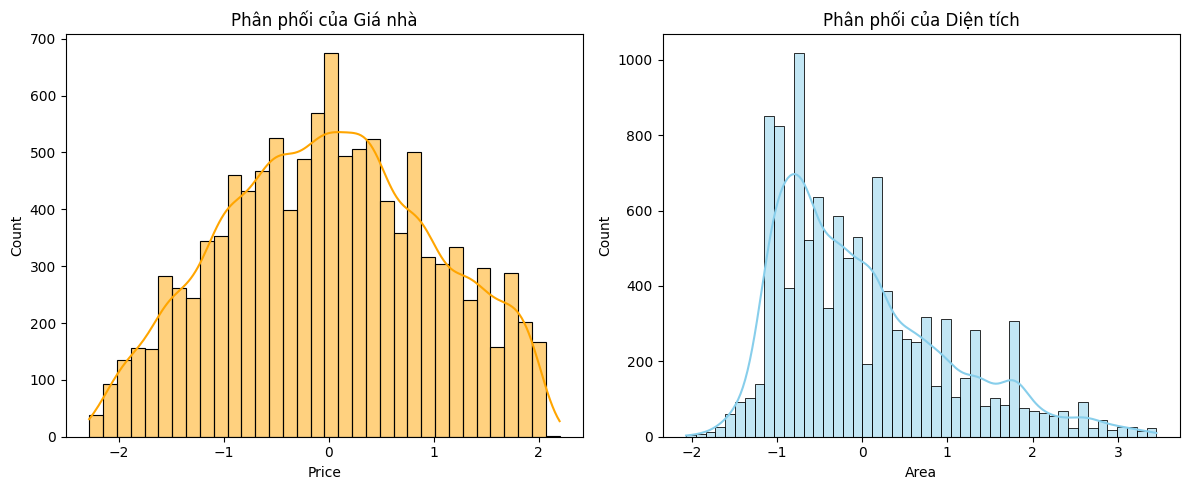

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(vietnam_housing_clean['Price'], kde=True, color='orange')
plt.title("Phân phối của Giá nhà")

plt.subplot(1, 2, 2)
sns.histplot(vietnam_housing_clean['Area'], kde=True, color='skyblue')
plt.title("Phân phối của Diện tích")

plt.tight_layout()
plt.show()

**Biểu đồ thanh (Barplot) thể hiện trung bình giá theo hướng nhà hoặc nội thất**

/tmp/ipykernel_8016/3859105761.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='Price', data=vietnam_housing_clean, estimator=np.mean, ci=None, palette="viridis")
/tmp/ipykernel_8016/3859105761.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='Price', data=vietnam_housing_clean, estimator=np.mean, ci=None, palette="viridis")


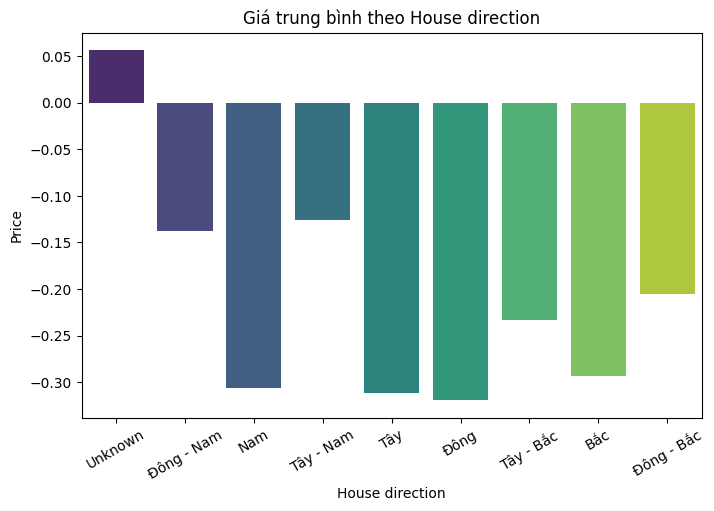

/tmp/ipykernel_8016/3859105761.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='Price', data=vietnam_housing_clean, estimator=np.mean, ci=None, palette="viridis")
/tmp/ipykernel_8016/3859105761.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='Price', data=vietnam_housing_clean, estimator=np.mean, ci=None, palette="viridis")


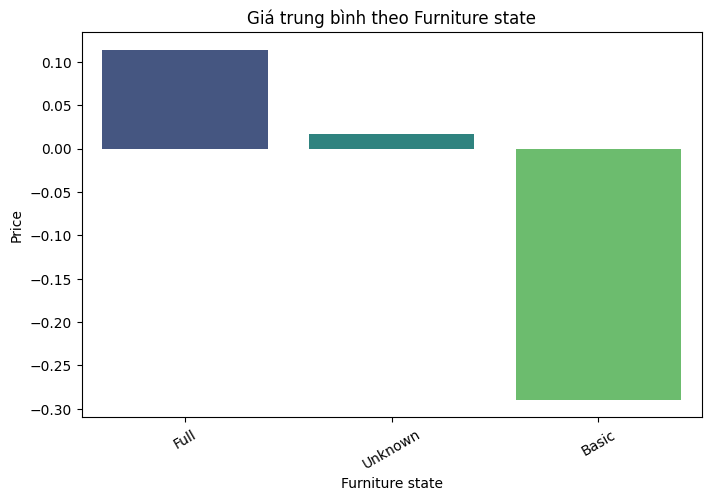

In [41]:
for col in ['House direction', 'Furniture state']:
    if col in vietnam_housing_clean.columns:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=col, y='Price', data=vietnam_housing_clean, estimator=np.mean, ci=None, palette="viridis")
        plt.title(f"Giá trung bình theo {col}")
        plt.xticks(rotation=30)
        plt.show()

## PHÂN CỤM DỮ LIỆU

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Định nghĩa các cột số và cột phân loại
num_cols = ['Area', 'Access Road', 'Frontage', 'Bedrooms', 'Bathrooms', 'Price',
            'House_direction_sin', 'House_direction_cos',
            'Balcony_direction_sin', 'Balcony_direction_cos','Legal_status_1','Furniture_status_1']



In [ ]:
num_cols = [c for c in num_cols if c in vietnam_housing_clean.columns]
X = vietnam_housing_clean[num_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Chạy KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
km_inertias, km_scores = [], []
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X_scaled, km.labels_))
    print(f"k={k} | Inertia={km.inertia_:.2f} | Silhouette={km_scores[-1]:.4f}")


k=3 | Inertia=10451.72 | Silhouette=0.2018
k=4 | Inertia=9094.63 | Silhouette=0.2212
k=5 | Inertia=7801.69 | Silhouette=0.2331
k=6 | Inertia=6915.47 | Silhouette=0.2262
k=7 | Inertia=6130.99 | Silhouette=0.2553
k=8 | Inertia=5798.39 | Silhouette=0.2230
k=9 | Inertia=5521.41 | Silhouette=0.2210


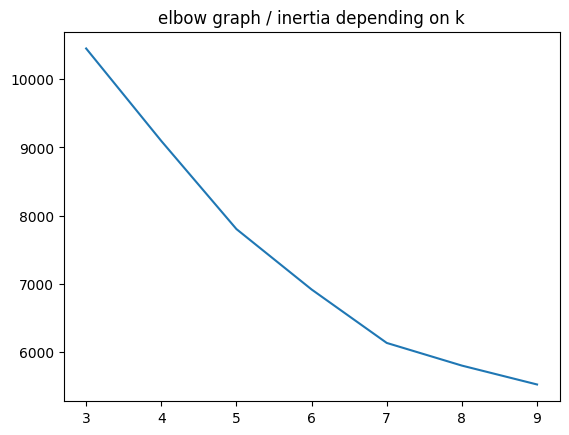

k = 3, Silhouette Score = 0.197
k = 4, Silhouette Score = 0.221
k = 5, Silhouette Score = 0.249
k = 6, Silhouette Score = 0.241
k = 7, Silhouette Score = 0.217
k = 8, Silhouette Score = 0.245
k = 9, Silhouette Score = 0.206


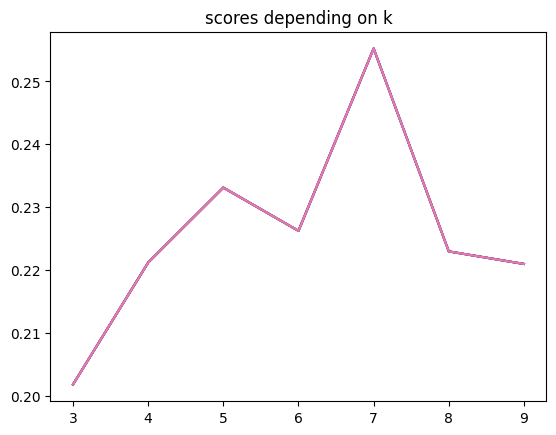

In [ ]:
# sns.lineplot(range(3, 10), km_inertias) PHUOCNT
sns.lineplot(x=range(3, 10), y=km_inertias)
plt.title('elbow graph / inertia depending on k')
plt.show()
# Bổ sung kiểm tra bằng Silhouette Score
from sklearn.metrics import silhouette_score
for k in range(3, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    sns.lineplot(x=range(3, 10), y=km_scores)
plt.title('scores depending on k')
plt.show()


In [ ]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=4).fit(X_scaled)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(4):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')
 

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   347.000000  347.000000  347.000000  347.000000  347.000000   
mean      0.743516    0.290428    0.789280    0.904532    0.989762   
std       1.042839    0.870322    0.750500    0.852747    0.733653   
min      -1.156542   -1.841048   -0.353546   -1.123815   -1.054508   
25%      -0.022743   -0.494076    0.885705    0.701960    0.473599   
50%       0.463170    0.179409    0.885705    0.701960    1.070516   
75%       1.677955    0.852895    0.885705    1.614848    1.571926   
max       3.054710    2.873353    2.124956    3.440622    2.288226   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count           347.000000           347.000000             347.000000   
mean             -0.123919             0.853026              -0.112392   
std               0.338611             0.378254               0.342621   
min              -1.000000            -1.000000           

In [ ]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=5).fit(X_scaled)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(5):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   123.000000  123.000000  123.000000  123.000000  123.000000   
mean      0.144232    0.006055   -0.010988   -0.040225    0.174578   
std       1.022590    1.003736    1.056088    1.092403    1.031604   
min      -1.156542   -2.514534   -1.592797   -2.036702   -1.813786   
25%      -0.670628   -0.494076   -0.353546   -1.123815   -0.708296   
50%      -0.184715   -0.359379   -0.353546   -0.210927    0.019942   
75%       0.787113    0.852895    0.885705    0.701960    0.951132   
max       2.406825    2.738655    2.124956    3.440622    2.288226   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count         1.230000e+02         1.230000e+02           1.230000e+02   
mean         -9.918699e-01        -8.130081e-03          -9.837398e-01   
std           9.016696e-02         9.016696e-02           1.269917e-01   
min          -1.000000e+00        -1.000000e+00          -

In [ ]:
print("KMeans n_clusters:", km.n_clusters)
print("Shape of X_scaled:", X_scaled.shape)
print("Unique cluster labels:", np.unique(X_scaled['Label']))
print("Number of duplicates:", vietnam_housing_clean.duplicated().sum())


KMeans n_clusters: 5
Shape of X_scaled: (1346, 11)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

**VISUALAZATION FOR K- MEANS**

**Biểu đồ phân cụm 2D (giảm chiều với PCA)**

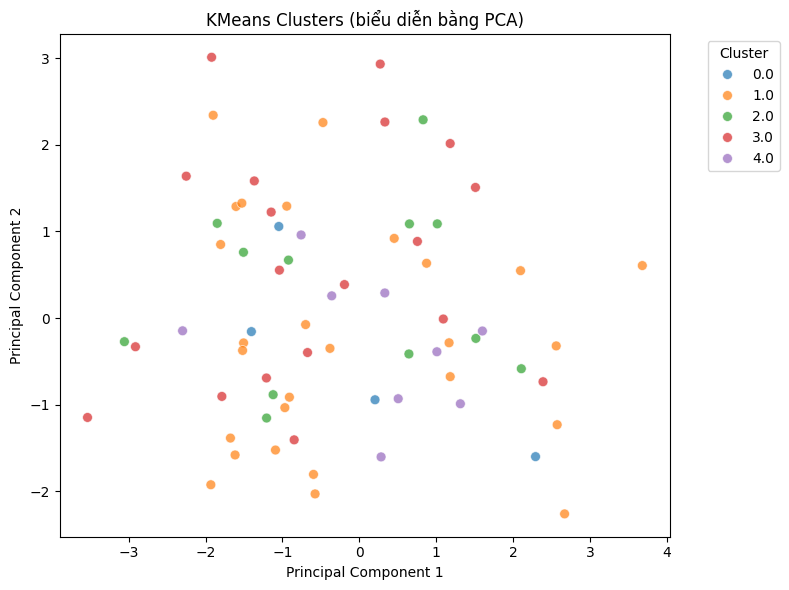

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử X là dữ liệu chuẩn hóa (không chứa cột Label)
X_features = X.drop(columns=['Label'], errors='ignore')

# Giảm chiều xuống 2 trục chính
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

# Tạo DataFrame cho trực quan
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = X['Label']

# Vẽ scatter plot các cụm
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Cluster',
    palette='tab10',
    alpha=0.7,
    s=50
)
plt.title('KMeans Clusters (biểu diễn bằng PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Boxplot so sánh các cụm theo từng biến**

/tmp/ipykernel_10899/144194897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_plot, x='Label', y=feature, palette='Set2')


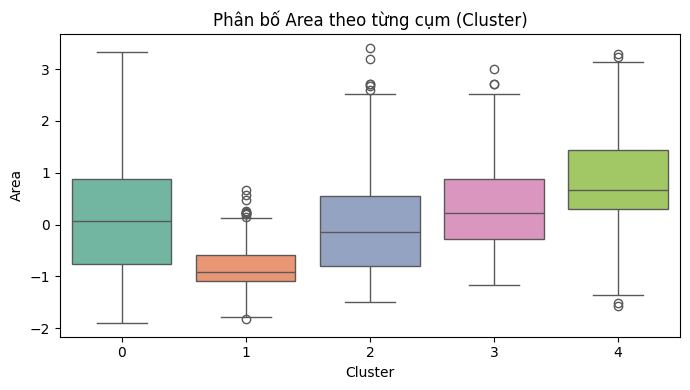

/tmp/ipykernel_10899/144194897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_plot, x='Label', y=feature, palette='Set2')


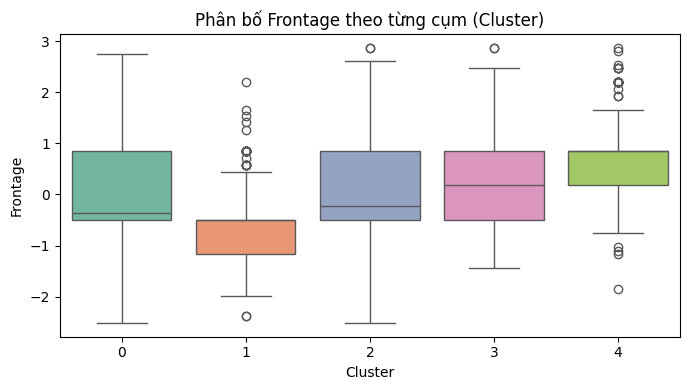

/tmp/ipykernel_10899/144194897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_plot, x='Label', y=feature, palette='Set2')


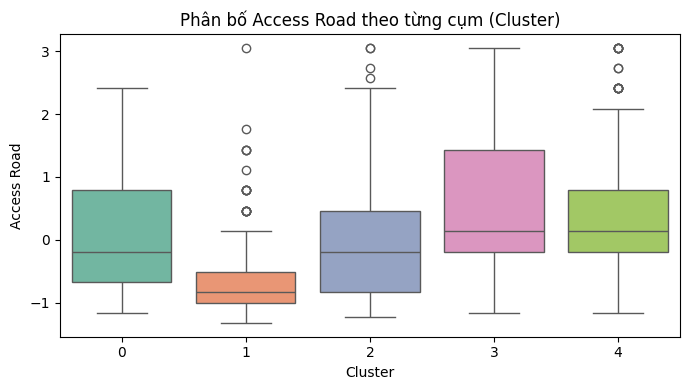

/tmp/ipykernel_10899/144194897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_plot, x='Label', y=feature, palette='Set2')


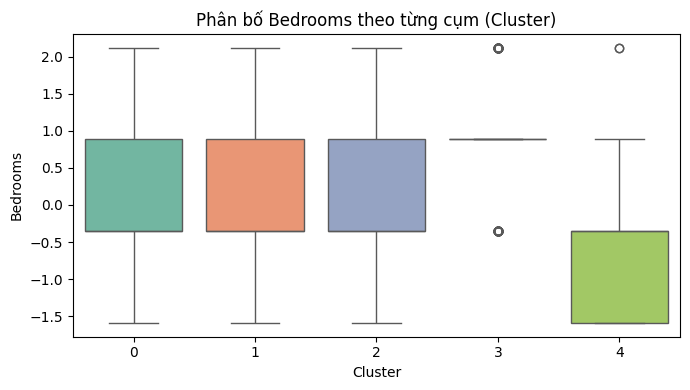

/tmp/ipykernel_10899/144194897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_plot, x='Label', y=feature, palette='Set2')


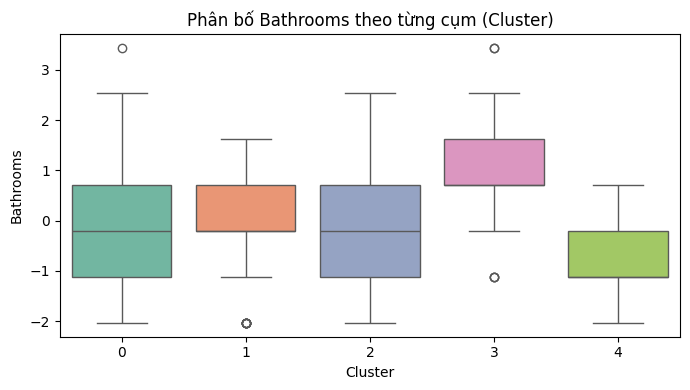

/tmp/ipykernel_10899/144194897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_plot, x='Label', y=feature, palette='Set2')


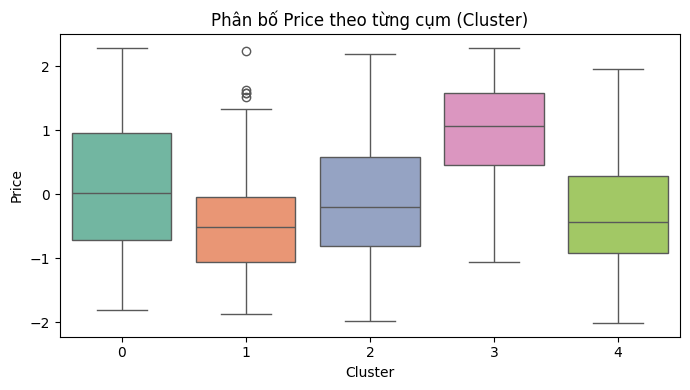

In [ ]:
features = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']
X_plot = X.copy()

for feature in features:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=X_plot, x='Label', y=feature, palette='Set2')
    plt.title(f'Phân bố {feature} theo từng cụm (Cluster)')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

**Heatmap trung bình các đặc trưng theo cụm**

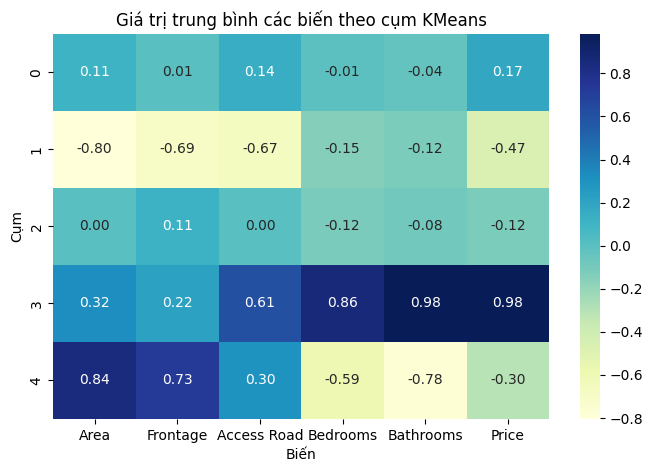

In [ ]:
cluster_summary = X.groupby('Label')[features].mean()

plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Giá trị trung bình các biến theo cụm KMeans')
plt.xlabel('Biến')
plt.ylabel('Cụm')
plt.show()

**Pairplot các biến chính**

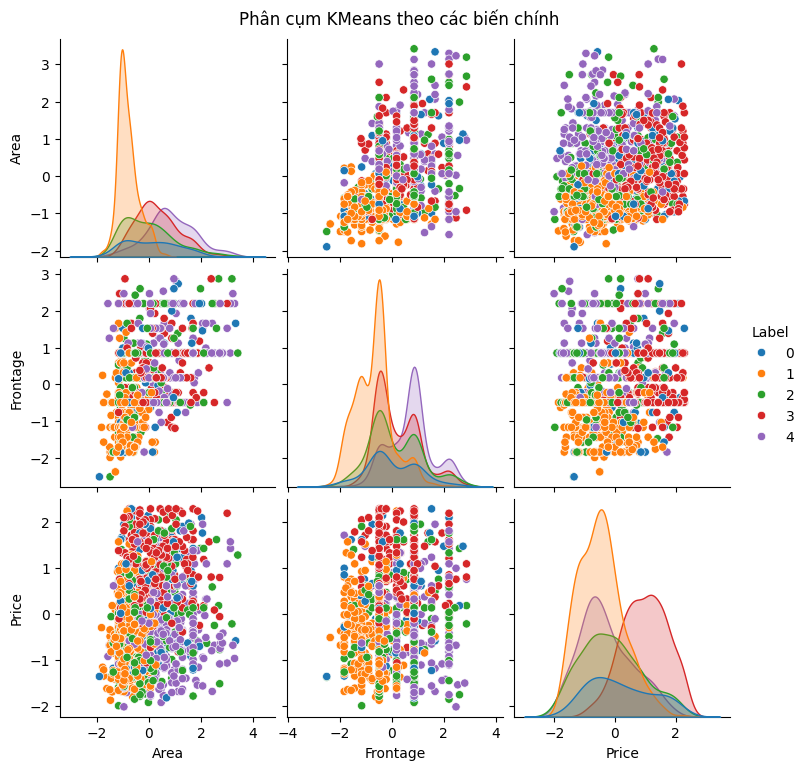

In [ ]:
sns.pairplot(X_plot, vars=['Area', 'Frontage', 'Price'], hue='Label', palette='tab10')
plt.suptitle('Phân cụm KMeans theo các biến chính', y=1.02)
plt.show()

## DBSCAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
df = vietnam_housing_clean.copy()
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df = df.rename(columns={'Access Road':'Access_Road'})
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df.rename(columns={'Access Road':'Access_Road'}, inplace=True)

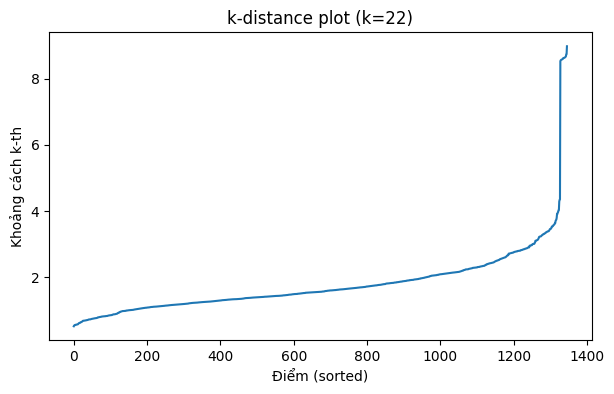

In [ ]:
k = max(5, 2*X_scaled.shape[1])  # rule of thumb
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
dist, _ = nbrs.kneighbors(X_scaled)
kdist = np.sort(dist[:, -1])

plt.figure(figsize=(7,4))
plt.plot(kdist); plt.title(f'k-distance plot (k={k})')
plt.xlabel('Điểm (sorted)'); plt.ylabel('Khoảng cách k-th'); plt.show()


In [ ]:
for eps_test in [1.2, 1.5, 1.8, 2.0, 2.3, 2.5]:
    db = DBSCAN(eps=eps_test, min_samples=10).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise = (labels == -1).mean()
    print(f"eps={eps_test}: cụm={n_clusters}, noise={noise:.2%}")


eps=1.2: cụm=8, noise=44.65%
eps=1.5: cụm=6, noise=20.28%
eps=1.8: cụm=2, noise=8.84%
eps=2.0: cụm=2, noise=4.61%
eps=2.3: cụm=1, noise=1.26%
eps=2.5: cụm=1, noise=0.37%


In [ ]:
# DBSCAN với eps = 1.5
db = DBSCAN(eps=1.5, min_samples=10).fit(X_scaled)
df['db'] = db.labels_

# K-Means để so sánh
km = KMeans(n_clusters=5, random_state=42).fit(X_scaled)
df['km'] = km.labels_

# Chỉ tính Silhouette nếu DBSCAN ra >=2 cụm khác nhau (bỏ noise -1)
mask = df['db'] != -1
n_clusters_db = len(set(df['db'][mask]))

if n_clusters_db > 1:
    print("Silhouette DBSCAN:", silhouette_score(X[mask], df['db'][mask]))
else:
    print("DBSCAN chỉ có 1 cụm hợp lệ → không tính được Silhouette")

print("Silhouette KMeans:", silhouette_score(X, df['km']))


Silhouette DBSCAN: 0.08377054944529565
Silhouette KMeans: 0.1955016433228415


**VISUALAZATION**

**Biểu đồ phân cụm 2D sau khi giảm chiều (PCA)**

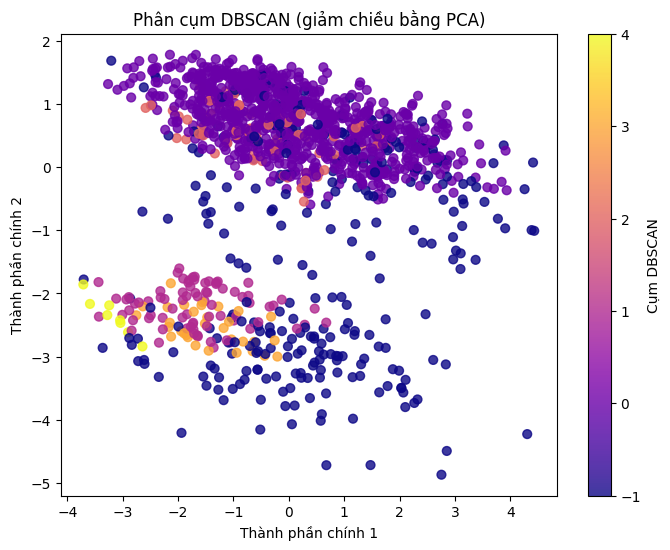

In [ ]:
from sklearn.decomposition import PCA

# Giảm chiều dữ liệu để vẽ 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['db'], cmap='plasma', s=40, alpha=0.8)
plt.title('Phân cụm DBSCAN (giảm chiều bằng PCA)')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.colorbar(label='Cụm DBSCAN')
plt.show()

**So sánh DBSCAN và KMeans trên cùng mặt phẳng PCA**

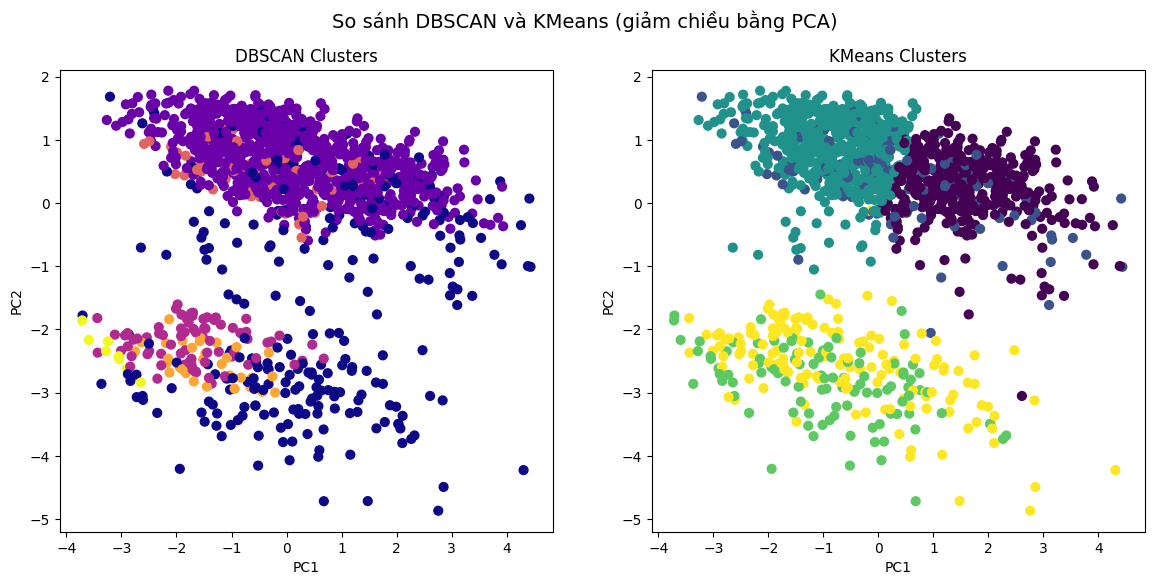

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# DBSCAN
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=df['db'], cmap='plasma', s=40)
ax[0].set_title('DBSCAN Clusters')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

# KMeans
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=df['km'], cmap='viridis', s=40)
ax[1].set_title('KMeans Clusters')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')

plt.suptitle('So sánh DBSCAN và KMeans (giảm chiều bằng PCA)', fontsize=14)
plt.show()

**Biểu đồ tần suất cụm DBSCAN**

/tmp/ipykernel_10899/3151818732.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='db', data=df, palette='plasma')


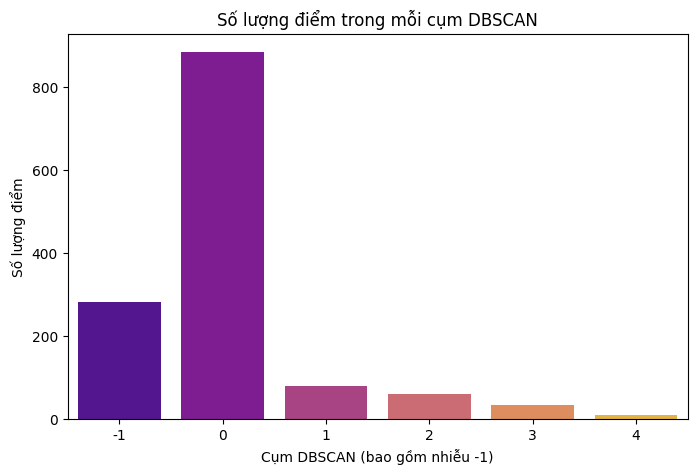

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='db', data=df, palette='plasma')
plt.title('Số lượng điểm trong mỗi cụm DBSCAN')
plt.xlabel('Cụm DBSCAN (bao gồm nhiễu -1)')
plt.ylabel('Số lượng điểm')
plt.show()

**Trực quan hóa vùng nhiễu**

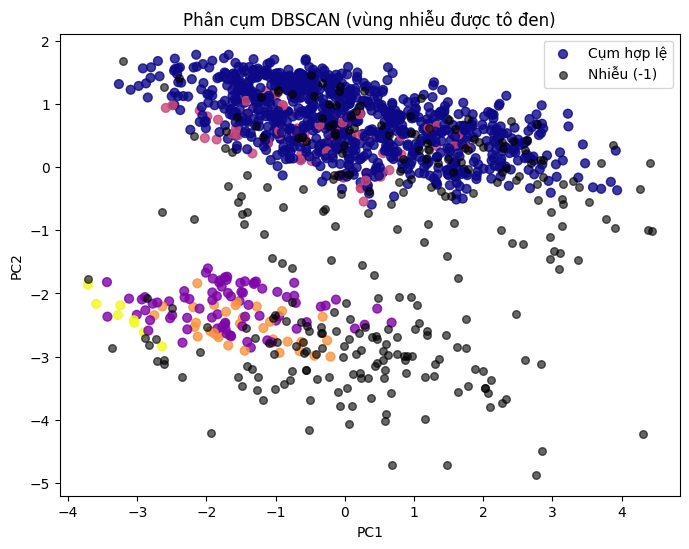

In [ ]:
plt.figure(figsize=(8,6))
mask_noise = df['db'] == -1
plt.scatter(X_pca[~mask_noise, 0], X_pca[~mask_noise, 1], c=df['db'][~mask_noise], cmap='plasma', s=40, alpha=0.8, label='Cụm hợp lệ')
plt.scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1], c='black', s=30, alpha=0.6, label='Nhiễu (-1)')
plt.title('Phân cụm DBSCAN (vùng nhiễu được tô đen)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Hierarchical clustering 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as pl

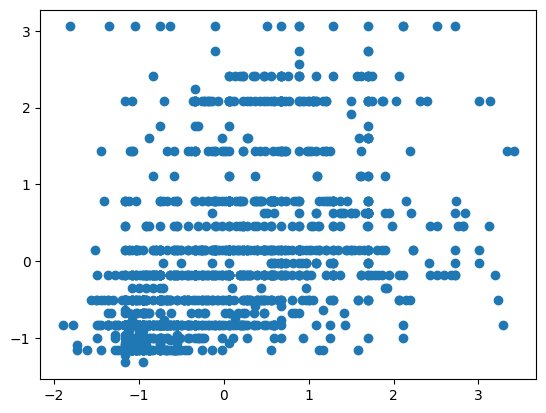

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
# Generate a random cluster dataset to experiment on. 
# X = coordinate points, y = cluster labels (not needed)
X, y = make_blobs(n_samples=1000, centers=8, n_features=2,
random_state=800)
plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.show()

In [ ]:
# Generate distance matrix with 'linkage' function
distances = linkage(X_scaled, method="centroid", metric="euclidean")
print(distances)

[[3.00000000e+00 2.15000000e+02 0.00000000e+00 2.00000000e+00]
 [5.24000000e+02 1.34100000e+03 0.00000000e+00 2.00000000e+00]
 [1.10200000e+03 1.16900000e+03 0.00000000e+00 2.00000000e+00]
 ...
 [2.69000000e+02 2.68700000e+03 5.56774766e+00 1.32600000e+03]
 [4.15000000e+02 2.68800000e+03 6.05171388e+00 1.32700000e+03]
 [2.68300000e+03 2.68900000e+03 8.72847764e+00 1.34600000e+03]]


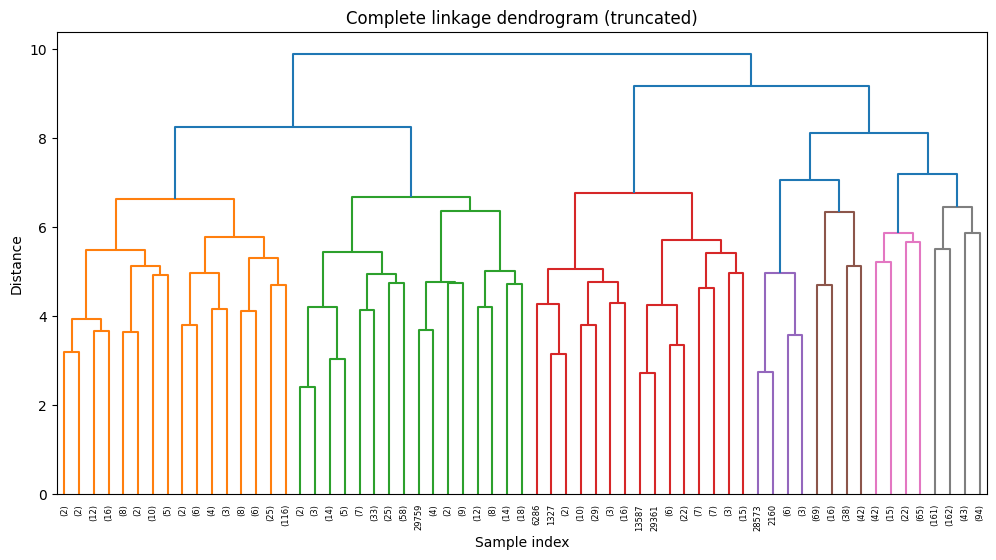

In [ ]:
# select numeric columns only (or list the feature column names you want)
numeric_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()
X_hier = vietnam_housing_clean[numeric_cols].dropna()

if X_hier.shape[0] < 2 or X_hier.shape[1] < 1:
    raise ValueError("Not enough numeric rows/columns for hierarchical clustering. Check vietnam_housing_clean.")

# convert to numpy array (float) for linkage
X_vals = X_hier.values.astype(float)

complete_clustering = linkage(X_vals, method="complete", metric="euclidean")
average_clustering  = linkage(X_vals, method="average",  metric="euclidean")
single_clustering   = linkage(X_vals, method="single",   metric="euclidean")

# optional: plot a truncated dendrogram for the complete linkage
plt.figure(figsize=(12, 6))
dendrogram(complete_clustering, truncate_mode='level', p=5, labels=X_hier.index)
plt.title("Complete linkage dendrogram (truncated)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

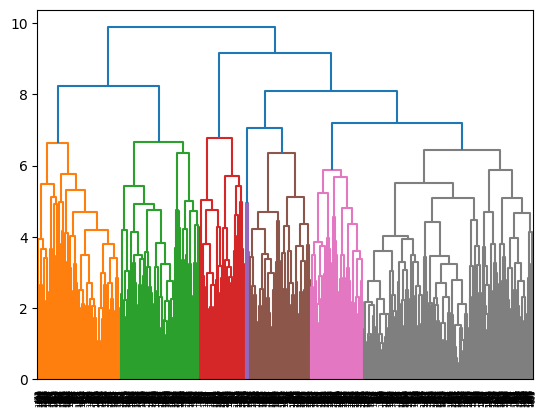

In [ ]:
dendrogram(complete_clustering)
plt.show()

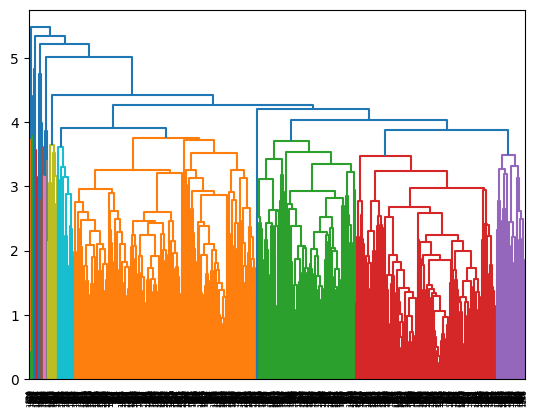

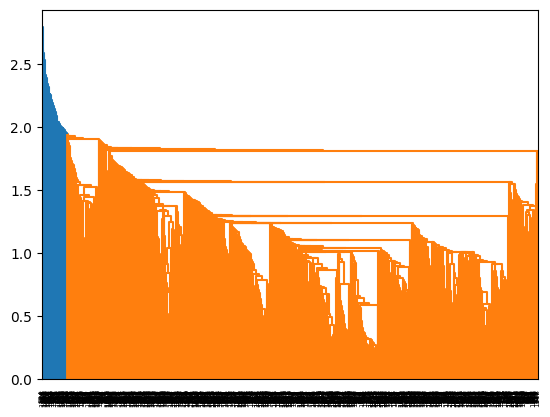

In [ ]:
dendrogram(average_clustering)
plt.show()
dendrogram(single_clustering)
plt.show()

best_k=2, silhouette=0.1853


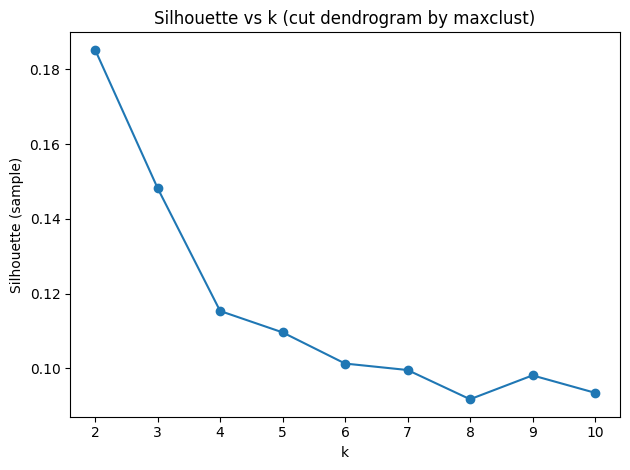

In [ ]:
Z = complete_clustering 
# Giả sử `X_hier` là DataFrame
n = len(X_hier)

# Chọn một mẫu ngẫu nhiên (số điểm không quá 2000)
idx = np.random.default_rng(42).choice(n, size=min(2000, n), replace=False)

# Trích xuất mẫu ngẫu nhiên từ X_hier bằng iloc
X_s = X_hier.iloc[idx]  # Sử dụng iloc để trích xuất các hàng theo chỉ số

# Tạo dải giá trị k từ 2 đến 10
k_grid = range(2, 11)

# Tính silhouette score cho mỗi k
sil_scores = [silhouette_score(X_s, fcluster(Z, t=k, criterion="maxclust")[idx]) for k in k_grid]

# Lấy k tối ưu
best_k = list(k_grid)[int(np.nanargmax(sil_scores))]

# In ra kết quả
print(f"best_k={best_k}, silhouette={np.nanmax(sil_scores):.4f}")

# Vẽ đồ thị silhouette score theo k
import matplotlib.pyplot as plt
plt.plot(list(k_grid), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (sample)")
plt.title("Silhouette vs k (cut dendrogram by maxclust)")
plt.tight_layout()
plt.show()


In [ ]:
labels_ser = pd.Series(labels, index=X_s.index, name="Cluster")
summary_rows = []
for c in sorted(np.unique(labels)):
    mask = (labels_ser.values == c)
    
    # Kiểm tra mask hợp lệ
    print(f"Cluster {c} - Mask shape: {mask.shape}, True count: {mask.sum()}")

    # Lấy median của các cột số trong X_s
    row = {"Cluster": int(c), "Count": int(mask.sum())}
    
    # Dùng iloc đúng cách (mask là mảng NumPy boolean)
    row.update(X_s.iloc[mask][numeric_cols].median().to_dict())
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values("Cluster").reset_index(drop=True)

from IPython.display import display
display(summary_df)


Cluster -1 - Mask shape: (1346,), True count: 5
Cluster 0 - Mask shape: (1346,), True count: 1341


Cluster  Count      Area  Frontage  Access Road  Floors  Bedrooms  \
0       -1      5 -0.671349 -0.359379    -0.508657     4.0 -0.353546   
1        0   1341 -0.140161 -0.359379    -0.184715     3.0 -0.353546   

   Bathrooms     Price  House_direction_sin  House_direction_cos  \
0   0.701960  0.187079                  0.0                  1.0   
1  -0.210927 -0.123318                  0.0                  1.0   

   Balcony_direction_sin  Balcony_direction_cos  
0                    0.0                    1.0  
1                    0.0                    1.0

/tmp/ipykernel_10899/3459741769.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y=target, data=df_cluster, palette="Set2")


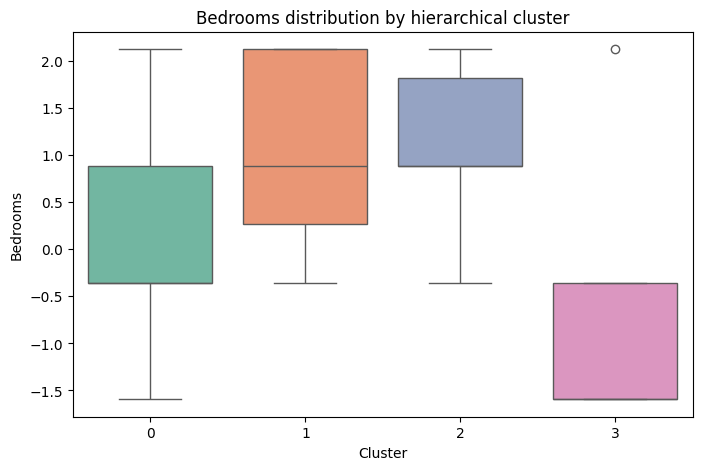

In [ ]:
from scipy.cluster.hierarchy import cut_tree
import seaborn as sns
import matplotlib.pyplot as plt
# Cắt cây dendrogram thành 2 cụm (đổi số nếu muốn)
cluster_labels = cut_tree(average_clustering, n_clusters=4).reshape(-1, )

# Gắn nhãn cụm vào dataframe đang dùng (X_hier hoặc vietnam_housing_scaled)
df_cluster = X_hier.copy()
df_cluster["Cluster"] = cluster_labels

# Chọn biến để xem ý nghĩa (ví dụ 'Price')
target = "Bedrooms"

# Vẽ boxplot để so sánh phân bố biến theo cụm
plt.figure(figsize=(8,5))
sns.boxplot(x="Cluster", y=target, data=df_cluster, palette="Set2")
plt.title(f"{target} distribution by hierarchical cluster")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
# 1. Chuẩn hóa
X = vietnam_housing_clean[num_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)
# 2. Linkage
Z = linkage(X_scaled, method='ward')
# 3. Cắt cụm (ví dụ 4 cụm)
labels = fcluster(Z, t=2, criterion='maxclust')
# 4. Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print("✅ Silhouette Score:", sil_score)

✅ Silhouette Score: 0.288238089865337


In [ ]:
for k in range(3, 7):
    labels_hier = fcluster(Z, t=k, criterion='maxclust')
    silhouette = silhouette_score(X_scaled, labels_hier)
    print(f"Silhouette Score for k={k}: {silhouette:.4f}")


Silhouette Score for k=3: 0.3266
Silhouette Score for k=4: 0.3198
Silhouette Score for k=5: 0.2297
Silhouette Score for k=6: 0.2577


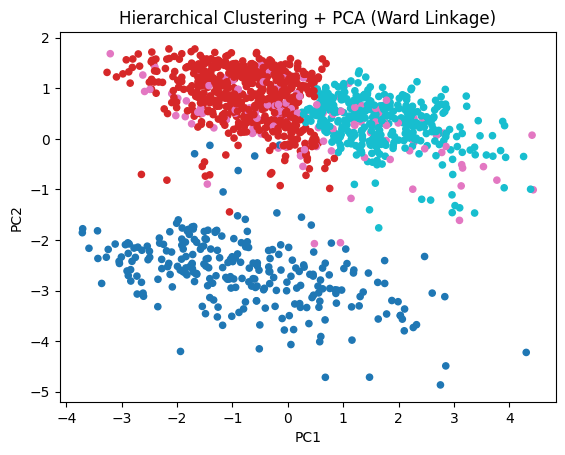

In [ ]:
from sklearn.decomposition import PCA

# Chọn số lượng thành phần PCA nhỏ hơn hoặc bằng số đặc trưng trong dữ liệu (ở đây là 5)
pca = PCA(n_components=3)  # Hoặc có thể chọn n_components=2 để giảm xuống 2 chiều
X_reduced = pca.fit_transform(X_scaled)

# Tiến hành phân cụm với dữ liệu giảm chiều
Z = linkage(X_reduced, method='ward')

# Cắt cụm với số cụm tùy chọn
labels_hier = fcluster(Z, t=4, criterion='maxclust')

# Hiển thị kết quả trực quan
pca = PCA(n_components=2)  # Giảm xuống 2 chiều để trực quan hóa
X_pca = pca.fit_transform(X_scaled)

# Vẽ scatter plot với các cụm khác nhau
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_hier, cmap='tab10', s=20)
plt.title("Hierarchical Clustering + PCA (Ward Linkage)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



In [ ]:
import numpy as np

print("Số cụm thật sự:", len(np.unique(labels)))
print("Phân bố nhãn:", np.unique(labels, return_counts=True))


Số cụm thật sự: 2
Phân bố nhãn: (array([1, 2], dtype=int32), array([ 219, 1127]))


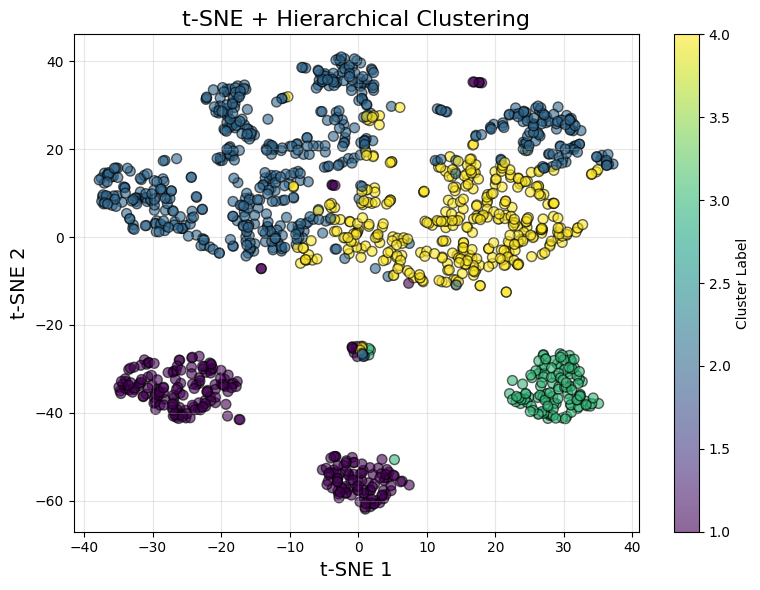

In [ ]:
from sklearn.manifold import TSNE

# Áp dụng t-SNE để giảm chiều xuống 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Vẽ scatter plot sau khi giảm chiều bằng t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_hier, cmap='viridis', s=50, alpha=0.6, edgecolors='k')
plt.title("t-SNE + Hierarchical Clustering", fontsize=16)
plt.xlabel("t-SNE 1", fontsize=14)
plt.ylabel("t-SNE 2", fontsize=14)
plt.colorbar(label='Cluster Label')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


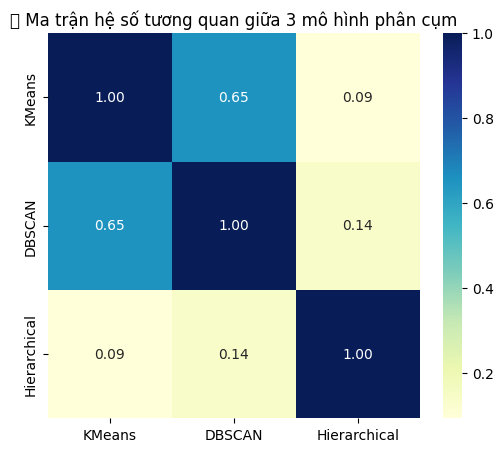

✅ Ma trận tương quan giữa các phương pháp phân cụm:


KMeans    DBSCAN  Hierarchical
KMeans        1.000000  0.653703      0.093254
DBSCAN        0.653703  1.000000      0.141305
Hierarchical  0.093254  0.141305      1.000000

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Giả sử các nhãn đã có:
# df['km'] – KMeans
# df['db'] – DBSCAN
# df_cluster['Cluster'] – Hierarchical

# 1️⃣ Gộp nhãn lại thành một DataFrame chung
compare_df = pd.DataFrame({
    'KMeans': df['km'].values,
    'DBSCAN': df['db'].values,
    'Hierarchical': df_cluster['Cluster'].reindex(df.index, fill_value=-1).values
})

# 2️⃣ Đảm bảo các giá trị đều là số (tránh lỗi khi tính)
for col in compare_df.columns:
    le = LabelEncoder()
    compare_df[col] = le.fit_transform(compare_df[col])

# 3️⃣ Hàm tính Cramér’s V giữa hai phân cụm
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# 4️⃣ Tạo ma trận hệ số tương quan
methods = ['KMeans', 'DBSCAN', 'Hierarchical']
coef_matrix = pd.DataFrame(index=methods, columns=methods, dtype=float)

for i in methods:
    for j in methods:
        coef_matrix.loc[i, j] = cramers_v(compare_df[i], compare_df[j])

# 5️⃣ Hiển thị ma trận
plt.figure(figsize=(6,5))
sns.heatmap(coef_matrix.astype(float), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("🔹 Ma trận hệ số tương quan giữa 3 mô hình phân cụm")
plt.show()

# 6️⃣ In kết quả chi tiết
print("✅ Ma trận tương quan giữa các phương pháp phân cụm:")
display(coef_matrix)


In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Giả sử các nhãn đã có
labels_km = df['km']
labels_db = df['db']
labels_hier = df_cluster['Cluster'].reindex(df.index, fill_value=-1)  # 🔁 đồng bộ index

# Loại bỏ noise trong DBSCAN
mask = labels_db != -1

# Lọc 3 nhãn theo mask (sử dụng .loc để tránh lỗi index)
labels_db_clean = labels_db.loc[mask]
labels_km_clean = labels_km.loc[mask]
labels_hier_clean = labels_hier.loc[mask]

# ✅ Tính ARI và AMI
compare_metrics = pd.DataFrame({
    "Model Comparison": [
        "KMeans vs DBSCAN",
        "KMeans vs Hierarchical",
        "DBSCAN vs Hierarchical"
    ],
    "ARI": [
        adjusted_rand_score(labels_km_clean, labels_db_clean),
        adjusted_rand_score(labels_km, labels_hier),
        adjusted_rand_score(labels_db_clean, labels_hier_clean)
    ],
    "AMI": [
        adjusted_mutual_info_score(labels_km_clean, labels_db_clean),
        adjusted_mutual_info_score(labels_km, labels_hier),
        adjusted_mutual_info_score(labels_db_clean, labels_hier_clean)
    ]
})
print(compare_metrics)



         Model Comparison       ARI       AMI
0        KMeans vs DBSCAN  0.403670  0.685296
1  KMeans vs Hierarchical  0.013661  0.019598
2  DBSCAN vs Hierarchical -0.014244 -0.002100


**VISUALIZATION**

**Phân bố cụm (Scatter Plot)**

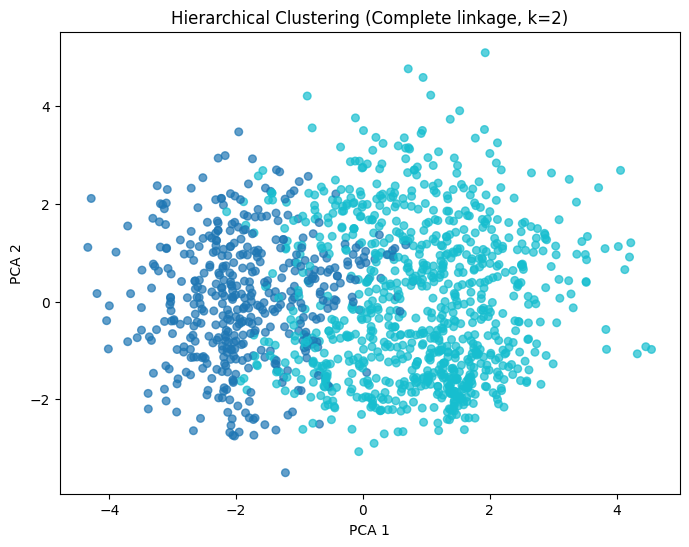

In [ ]:
from sklearn.decomposition import PCA

# Giảm về 2 chiều để vẽ
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_s)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels[idx], cmap='tab10', s=30, alpha=0.7)
plt.title(f"Hierarchical Clustering (Complete linkage, k={best_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

**Boxplot mô tả đặc trưng từng cụm**

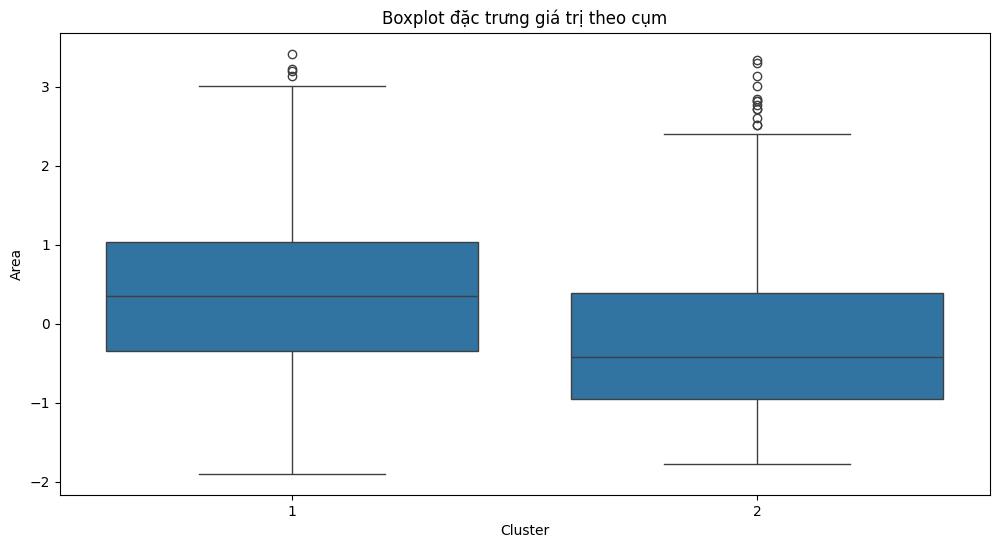

In [ ]:
import seaborn as sns
clustered = X_hier.copy()
clustered['Cluster'] = fcluster(Z, t=best_k, criterion='maxclust')

plt.figure(figsize=(12, 6))
sns.boxplot(data=clustered, x='Cluster', y='price' if 'price' in clustered.columns else clustered.columns[0])
plt.title("Boxplot đặc trưng giá trị theo cụm")
plt.show()

**Heatmap trung vị đặc trưng cụm**

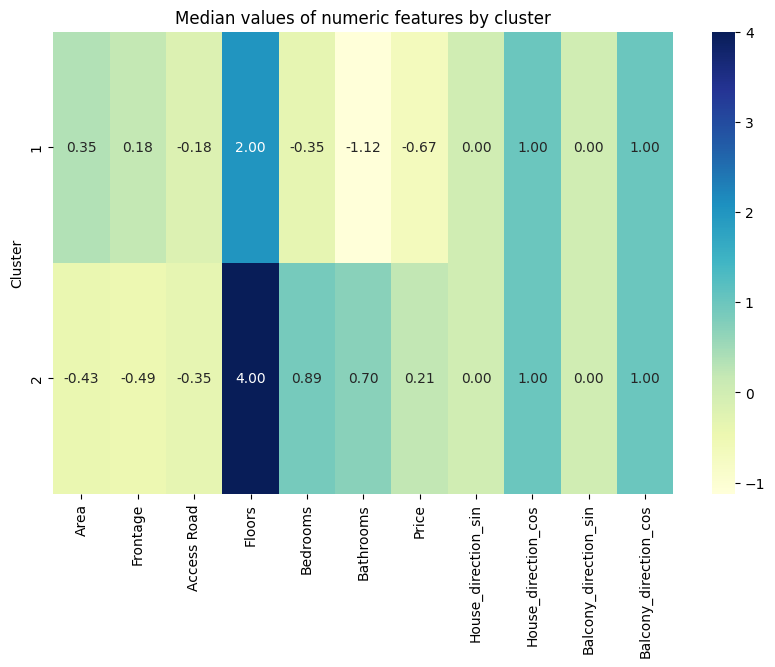

In [ ]:
summary = clustered.groupby('Cluster')[numeric_cols].median()
plt.figure(figsize=(10, 6))
sns.heatmap(summary, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Median values of numeric features by cluster")
plt.show()

**Biểu đồ Silhouette cho từng điểm**

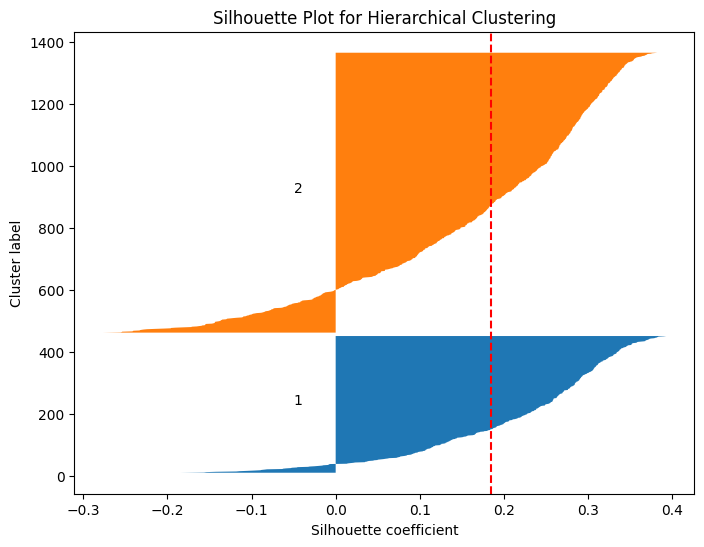

In [ ]:
from sklearn.metrics import silhouette_samples
import numpy as np

sil_vals = silhouette_samples(X_s, labels[idx])
y_lower = 10

plt.figure(figsize=(8,6))
for i in range(1, best_k + 1):
    cluster_sil_vals = sil_vals[labels[idx] == i]
    cluster_sil_vals.sort()
    y_upper = y_lower + len(cluster_sil_vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_sil_vals)
    plt.text(-0.05, y_lower + 0.5 * len(cluster_sil_vals), str(i))
    y_lower = y_upper + 10

plt.axvline(x=np.mean(sil_vals), color="red", linestyle="--")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster label")
plt.title("Silhouette Plot for Hierarchical Clustering")
plt.show()